# Simulate Ultimatum Game Experiment

**Analogous human experiment:**
* Houser, D.; and McCabe, K. 2014. Chapter 2 - Experimental Economics and Experimental Game Theory. In Glimcher, P. W.; and Fehr, E., eds., *Neuroeconomics (Second Edition)*, 19–34. San Diego: Academic Press, second edition edition. ISBN 978-0-12-416008-8.
* Krawczyk, D. C. 2018. Chapter 12 - Social Cognition: Reasoning With Others. In Krawczyk, D. C., ed., *Reasoning*, 283–311. Academic Press. ISBN 978-0-12-809285-9.

## 1. Set-Up

In [1]:
%load_ext autoreload
%autoreload 2

### 1.1. Imports

In [2]:
import pathlib
import pandas as pd
from tqdm import tqdm

In [3]:
import sys

# Add src module to path before import.
sys.path.insert(0, str(pathlib.Path('../src')))

from file_IO_handler import get_plaintext_file_contents
from openai_handler import verify_openai_access, OpenAIModelSettings, ENGINES
from fill_string_template import get_filled_strings_from_dataframe, FilledString
from run_simulation import run_single_simulation, save_simulation_result_to_unique_location
from process_results import consolidate_jsons_to_mega_json, process_mega_json_for_no_complete_prompt

### 1.2. Language Model Settings

In [4]:
verify_openai_access(
    path_to_organization=pathlib.Path("../openai_organization.txt"),
    path_to_api_key=pathlib.Path("../openai_api_key.txt")
)

In [5]:
model_settings = OpenAIModelSettings(engine="text-ada-001")
print(model_settings)

{'engine': 'text-ada-001', 'max_tokens': 0, 'temperature': 1, 'n': 1, 'logprobs': 1, 'echo': True, 'presence_penalty': 0, 'frequency_penalty': 0, 'stop': None, 'params_descriptor': 'no-complete-logprobs'}


### 1.3. Prompt Settings

In [6]:
RANDOM_SEED = 42

In [7]:
# Select 2-choice prompts.
prompt_descriptor_accept = "no-complete-accept"
prompt_descriptor_reject = "no-complete-reject"

In [8]:
# Set file paths to load simulation inputs
path_to_template_prompt_accept = pathlib.Path(
        "../data/prompt-templates/ultimatum_game/"
).joinpath(f"{prompt_descriptor_accept}.txt")

path_to_template_prompt_reject = pathlib.Path(
        "../data/prompt-templates/ultimatum_game/"
).joinpath(f"{prompt_descriptor_reject}.txt")

### 1.4. Participant Details Settings
Select data or data files to fill the simulation's participant details from.

In [9]:
experiment_descriptor_names = "surnames"

path_to_fills_names = pathlib.Path(
        "../data/external/"
).joinpath(f"{experiment_descriptor_names}.json")

HONORIFICS = ["Mr.", "Ms."]

### 1.5. Experimental Conditions Settings
Select data or data files to fill the simulation's experiment conditions from.

In [10]:
total_money = 10

### 1.6. Save Files and Outputs Settings

In [11]:
experiment_descriptor = f"UG_{experiment_descriptor_names}_total_money_{total_money}"

print(experiment_descriptor)

UG_surnames_total_money_10


In [12]:
path_to_filled_prompts = pathlib.Path(
        "../data/prompt-fills/ultimatum_game/"
).joinpath(f"{experiment_descriptor}.tsv")

path_to_simulation_results_folder = pathlib.Path(
        f"../data/simulation_results/ultimatum_game/"
)

path_to_simulation_results_consolidated_folder = pathlib.Path(
        "../data/simulation_results_consolidated/ultimatum_game/"
)

path_to_simulation_results_processed_folder = pathlib.Path(
        f"../data/simulation_results_processed/ultimatum_game/"
)

path_to_figures_folder = pathlib.Path(
        f"../results/ultimatum_game/"
)

## 2. Get Prompt Templates

In [13]:
template_prompt_accept = get_plaintext_file_contents(
    path_to_template_prompt_accept
)
print(template_prompt_accept)

In the following scenario, $player2 had to decide whether to accept or reject the proposal.

Scenario: $player1 is given $$$money. $player1 will propose how to split the money between $player1_self and $player2. Then $player2 will decide whether to accept or reject $player1's proposal. If $player2 accepts, then $player1 and $player2 get the money as they agreed to split. If $player2 rejects, then $player1 and $player2 both receive nothing. $player1 takes $$$keep for $player1_self and offers $player2 $$$offer.

Answer: $player2 decides to accept


In [14]:
# Define prompt_descriptor for later.
path_to_template_prompt_reject = get_plaintext_file_contents(
    path_to_template_prompt_reject
)
print(path_to_template_prompt_reject)

In the following scenario, $player2 had to decide whether to accept or reject the proposal.

Scenario: $player1 is given $$$money. $player1 will propose how to split the money between $player1_self and $player2. Then $player2 will decide whether to accept or reject $player1's proposal. If $player2 accepts, then $player1 and $player2 get the money as they agreed to split. If $player2 rejects, then $player1 and $player2 both receive nothing. $player1 takes $$$keep for $player1_self and offers $player2 $$$offer.

Answer: $player2 decides to reject


## 3. Fill Prompt Templates

### 3.1. Prepare values for `$player1` and `$player2`

#### 3.1.1. Honorific

In [15]:
print("Unique honorific values:", HONORIFICS)

Unique honorific values: ['Mr.', 'Ms.']


#### 3.1.2. Surname

In [16]:
df_surnames = pd.read_json(path_to_fills_names)

# Rename columns for concise titles in analysis.
df_surnames = df_surnames.rename(columns={
    "Black or African American": "Black",
    "White": "White",
    "Asian and Native Hawaiian and Other Pacific Islander": "Asian",
    "American Indian and Alaska Native": "Indigenous",
    "Hispanic or Latino": "Latino"
})

# Reshape dataframe so that rows are ["Race", "Surname"].
df_surnames = df_surnames.melt()
df_surnames["Surname"] = df_surnames.apply(
    lambda x: x["value"].capitalize(), 
    axis=1
)
df_surnames = df_surnames.drop(columns=["value"])
df_surnames = df_surnames.rename(columns={"variable": "Race"})

# Randomly shuffle rows so surnames are not sorted by popularity.
# Important for simulations requiring participant pairings or random samples.
df_surnames = df_surnames.sample(frac=1, random_state=RANDOM_SEED)

display(df_surnames)

Race      Surname
361  Indigenous       Kanuho
73        Black       Kidane
374  Indigenous       Dayzie
155       White        Cline
104       White      Schmidt
..          ...          ...
106       White       Hansen
270       Asian         Dinh
348  Indigenous  Smallcanyon
435      Latino     Alvarado
102       White       Wagner

[500 rows x 2 columns]

In [17]:
# Check that all surnames are unique.
print(
    "All surnames are unique:", 
    len(df_surnames["Surname"].unique()) == df_surnames.shape[0]
)

All surnames are unique: True


In [18]:
# Check that there is an even distribution of surnames.
display(df_surnames["Race"].value_counts())

# Define RACE options list.
RACE = list(df_surnames["Race"].unique())
print("Unique race values:", RACE)

Indigenous    100
Black         100
White         100
Latino        100
Asian         100
Name: Race, dtype: int64

Unique race values: ['Indigenous', 'Black', 'White', 'Latino', 'Asian']


### 3.2. Prepare values for `$money`

In [19]:
print("total_money", total_money)

total_money 10


### 3.3. Create dataframe of fills

Create a dataframe where each row contains experimental conditions and participant details for one Garden Path experiment simulation.

In [20]:
def create_dataframe_of_fills_for_ultimatum_game_simulation(
    df_surnames: pd.DataFrame,
    honorifics: list[str],
    total_money: int,
):
    """Create dataframe of fills for ultimatum game simulation.

    Args:
        df_surnames: (pandas dataframe) with columns:
            ["Race", "Surname"]
        honorifics: (list) strings, for example ["Mr.", "Ms."]
        total_money: money in pool.
    
    Returns:
        (pandas dataframe) with columns:
            [
                "player1", "player1_surname", "player1_gender", "player1_race", "player1_self", "player1_poss",
                "player2", "player2_surname", "player2_gender", "player2_race", "player2_self", "player2_poss",
                "money", "keep", "offer"
            ]
    """
    res = {
        "player1": [],
        "player1_surname": [],
        "player1_gender": [],
        "player1_race": [],
        "player1_self": [],
        "player1_poss": [],
        "player2": [],
        "player2_surname": [],
        "player2_gender": [],
        "player2_race": [],
        "player2_self": [],
        "player2_poss": [],
        "money": [],
        "keep": [],
        "offer": []
    }

    races = list(df_surnames["Race"].unique())
    for race1 in races:
        for race2 in races:
            # If making pairing within the same race,
            # shift list by 1 before zipping.
            # So that name 0 is paired with name 1, 
            # name 1 with name 2, ... name n with name 0
            if (race1 == race2):
                df_filtered_by_race = df_surnames[df_surnames["Race"] == race1]
                surnames = df_filtered_by_race["Surname"].tolist()
                group1_surnames = surnames
                group2_surnames = surnames[1:] + [surnames[0]]
                length = len(group1_surnames)

            # Else make pairing zipper style,
            # So that name 0 of both races are paired, 
            # name 1 of both are paired, name 2 of both are paired, etc.            
            else:
                df_group1 = df_surnames[df_surnames["Race"] == race1]
                group1_surnames = df_group1["Surname"].tolist()
                df_group2 = df_surnames[df_surnames["Race"] == race2]
                group2_surnames = df_group2["Surname"].to_list()
                if len(group1_surnames) != len(group2_surnames):
                    raise ValueError(f"{race1} and {race2} have unequal numbers of surnames! For even pairings, there should be an equal number of names for each race in `df_surnames`.")
                length = len(group1_surnames)
                
            # Loop through values to create all combinations of fills.
            for offer in range(total_money+1):
                for honorific1 in honorifics:
                    group1_names = [f"{honorific1} {surname}" for surname in group1_surnames]
                    for honorific2 in honorifics:
                        group2_names = [f"{honorific2} {surname}" for surname in group2_surnames]

                        res["player1"].extend(group1_names)
                        res["player1_surname"].extend(group1_surnames)
                        res["player1_gender"].extend([honorific1] * length)
                        res["player1_race"].extend([race1] * length)

                        res["player2"].extend(group2_names)
                        res["player2_surname"].extend(group2_surnames)
                        res["player2_gender"].extend([honorific2] * length)
                        res["player2_race"].extend([race2] * length)

                        res["offer"].extend([offer] * length)
                        res["keep"].extend([total_money - offer] * length)

    # Derivative values: gender
    for gender in res["player1_gender"]:
        if gender == "Ms.":
            res["player1_self"].append("herself")
            res["player1_poss"].append("her")
        elif gender == "Mr.":
            res["player1_self"].append("himself")
            res["player1_poss"].append("his")
        else:
            raise NotImplementedError(f"Logic for gender {gender} is not implemented.")

    for gender in res["player2_gender"]:
        if gender == "Ms.":
            res["player2_self"].append("herself")
            res["player2_poss"].append("her")
        elif gender == "Mr.":
            res["player2_self"].append("himself")
            res["player2_poss"].append("his")
        else:
            raise NotImplementedError(f"Logic for gender {gender} is not implemented.")

    # Derivative values: money
    res["money"].extend([total_money] * len(res["player1"]))

    return pd.DataFrame(res)    

In [21]:
dataframe_of_fills = create_dataframe_of_fills_for_ultimatum_game_simulation(
    df_surnames=df_surnames,
    honorifics=HONORIFICS,
    total_money=total_money
)
display(dataframe_of_fills.head(2))
print(dataframe_of_fills.shape)

player1 player1_surname player1_gender player1_race player1_self  \
0  Mr. Kanuho          Kanuho            Mr.   Indigenous      himself   
1  Mr. Dayzie          Dayzie            Mr.   Indigenous      himself   

  player1_poss      player2 player2_surname player2_gender player2_race  \
0          his   Mr. Dayzie          Dayzie            Mr.   Indigenous   
1          his  Mr. Lasiloo         Lasiloo            Mr.   Indigenous   

  player2_self player2_poss  money  keep  offer  
0      himself          his     10    10      0  
1      himself          his     10    10      0

(110000, 15)


In [22]:
dataframe_of_fills[
    (dataframe_of_fills["player1_race"] == "Asian") & (dataframe_of_fills["player2_race"] == "Asian")
].groupby(
    ["player1_surname", "player2_surname"]
).count()[["offer"]]

offer
player1_surname player2_surname       
Begum           Hwang               44
Bui             Vang                44
Cao             Chung               44
Chau            Song                44
Chen            Cheung              44
...                                ...
Zhang           Dinh                44
Zhao            Zhu                 44
Zheng           Dang                44
Zhou            He                  44
Zhu             Lim                 44

[100 rows x 1 columns]

*Note on speed:* Since each simulation can be run independently of other simulations, moderate speed-ups can be achieved by running simulations in parallel (i.e., simultaneously running scripts that read different sections of the dataframe of fills). When running scripts in parallel, be considerate of language model API rate limits.

In [23]:
# Uncomment to save dataframe of fills.
# dataframe_of_fills.to_csv(
#     path_to_filled_prompts, 
#     sep="\t"
# )

### 3.4. Get Filled Strings

In [24]:
filled_strings_prompt_accept = get_filled_strings_from_dataframe(
    string_template=template_prompt_accept,
    dataframe_of_fills=dataframe_of_fills
)

print(filled_strings_prompt_accept[0])

{'filled': "In the following scenario, Mr. Dayzie had to decide whether to accept or reject the proposal.\n\nScenario: Mr. Kanuho is given $10. Mr. Kanuho will propose how to split the money between himself and Mr. Dayzie. Then Mr. Dayzie will decide whether to accept or reject Mr. Kanuho's proposal. If Mr. Dayzie accepts, then Mr. Kanuho and Mr. Dayzie get the money as they agreed to split. If Mr. Dayzie rejects, then Mr. Kanuho and Mr. Dayzie both receive nothing. Mr. Kanuho takes $10 for himself and offers Mr. Dayzie $0.\n\nAnswer: Mr. Dayzie decides to accept", 'template': "In the following scenario, $player2 had to decide whether to accept or reject the proposal.\n\nScenario: $player1 is given $$$money. $player1 will propose how to split the money between $player1_self and $player2. Then $player2 will decide whether to accept or reject $player1's proposal. If $player2 accepts, then $player1 and $player2 get the money as they agreed to split. If $player2 rejects, then $player1 and 

In [25]:
filled_strings_prompt_reject = get_filled_strings_from_dataframe(
    string_template=path_to_template_prompt_reject,
    dataframe_of_fills=dataframe_of_fills
)

print(filled_strings_prompt_reject[0])

{'filled': "In the following scenario, Mr. Dayzie had to decide whether to accept or reject the proposal.\n\nScenario: Mr. Kanuho is given $10. Mr. Kanuho will propose how to split the money between himself and Mr. Dayzie. Then Mr. Dayzie will decide whether to accept or reject Mr. Kanuho's proposal. If Mr. Dayzie accepts, then Mr. Kanuho and Mr. Dayzie get the money as they agreed to split. If Mr. Dayzie rejects, then Mr. Kanuho and Mr. Dayzie both receive nothing. Mr. Kanuho takes $10 for himself and offers Mr. Dayzie $0.\n\nAnswer: Mr. Dayzie decides to reject", 'template': "In the following scenario, $player2 had to decide whether to accept or reject the proposal.\n\nScenario: $player1 is given $$$money. $player1 will propose how to split the money between $player1_self and $player2. Then $player2 will decide whether to accept or reject $player1's proposal. If $player2 accepts, then $player1 and $player2 get the money as they agreed to split. If $player2 rejects, then $player1 and 

## 4. Run Experiment

In [26]:
def simulate_experiment(
    filled_strings: list[FilledString],
    model_settings: OpenAIModelSettings,
    prompt_descriptor: str,
    experiment_descriptor: str,
    save_folder: pathlib.Path,
    seconds_to_sleep_before_query: int = 2,
    seconds_to_sleep_after_failed_query: int = 60,
    max_attempts: int = 3,
):
    """Run experiment and save results.

    Args:
        filled_strings: list of `Filled_String`, one per simulation
        model_settings: OpenAI_Model_Settings when querying language model
        prompt_descriptor: descriptor for prompt.
        experiment_descriptor: descriptor for experiment.
        save_folder: path of folder to save outputs to.
        seconds_to_sleep_before_query: seconds to sleep before querying language model.
        seconds_to_sleep_after_failed_query: (int) seconds to sleep after failed query.
        max_attempts: (int) number of tries to ping the API before returning

    Returns:
        None
    """
    for filled_string in tqdm(filled_strings):
        res = run_single_simulation(
            filled_string=filled_string,
            model_settings=model_settings,
            prompt_descriptor=prompt_descriptor,
            experiment_descriptor=experiment_descriptor,
            seconds_to_sleep_before_query=seconds_to_sleep_before_query,
            seconds_to_sleep_after_failed_query=seconds_to_sleep_after_failed_query,
            max_attempts=max_attempts,
        )
        if res is None:
            print("Breaking loop because `run_single_simulation` returned None.")
            break
        else:
            save_simulation_result_to_unique_location(
                res=res,
                save_folder=save_folder,
                prompt_descriptor=prompt_descriptor,
                experiment_descriptor=experiment_descriptor
            )
    return None

For demo purposes, run only 2 simulations for each prompt (4 queries total).

In [27]:
# simulate_experiment(
#     filled_strings=filled_strings_prompt_grammatical[0:2],
#     model_settings=model_settings,
#     prompt_descriptor=prompt_descriptor_grammatical,
#     experiment_descriptor=experiment_descriptor,
#     save_folder=path_to_simulation_results,
#     seconds_to_sleep_before_query=0,
#     seconds_to_sleep_after_failed_query=60,
#     max_attempts=3
# )

In [28]:
# simulate_experiment(
#     filled_strings=filled_strings_prompt_ungrammatical[0:2],
#     model_settings=model_settings,
#     prompt_descriptor=prompt_descriptor_ungrammatical,
#     experiment_descriptor=experiment_descriptor,
#     save_folder=path_to_simulation_results,
#     seconds_to_sleep_before_query=0,
#     seconds_to_sleep_after_failed_query=60,
#     max_attempts=3
# )

## 5. Consolidate Experiment Results
Choose set of simulation results for analysis. Since each result is in a different file, opening and loading each file takes some time.

In [29]:
# consolidate_jsons_to_mega_json(
#     open_file_pattern=path_to_simulation_results,
#     save_file_path=path_to_simulation_results_consolidated
# )

## 6. Process Simulation Results

In [30]:
def process_mega_jsons(engines: list[str]):
    """Processes mega jsons.

    Args:
        engines: list of engines
    
    Returns: 
        dict whose keys are engines.
    """
    dict_df_results = dict()
    for engine in engines:
        temp_dfs = {
            prompt_descriptor_accept: None,
            prompt_descriptor_reject: None
        }
        for prompt_descriptor in [prompt_descriptor_accept, prompt_descriptor_reject]:
            
            df = process_mega_json_for_no_complete_prompt(
                path_to_megajson=path_to_simulation_results_consolidated_folder / f"{experiment_descriptor}_{engine}_{prompt_descriptor}.json.gz", 
                completion_is_last_n_tokens_of_echoed_prompt=1,
            )

            print(engine, prompt_descriptor, df["tokens"].value_counts())

            # Rename probability and token columns, then drop weird column.
            df = df.rename(
                columns={
                    "probability": "original p(accept)" if prompt_descriptor == prompt_descriptor_accept else "original p(reject)", 
                    "tokens": "token accept" if prompt_descriptor == prompt_descriptor_accept else "token reject"
                }
            ).drop(columns=["Unnamed: 0"])

            temp_dfs[prompt_descriptor] = df

        # Merge into single dataframe.
        df_result = temp_dfs[prompt_descriptor_accept].merge(
            temp_dfs[prompt_descriptor_reject],
            on=["index", 
                "engine", 
                "money", 
                "keep", 
                "offer", 
                "player1", 
                "player1_surname", 
                "player1_gender", 
                "player1_race",
                "player1_self",
                "player1_poss",
                "player2", 
                "player2_surname", 
                "player2_gender", 
                "player2_race",
                "player2_self",
                "player2_poss"
            ]
        )

        # Get total probability of valid completions.
        df_result["p(valid)"] = df_result["original p(accept)"] + df_result["original p(reject)"]
        df_result["p(invalid)"] = 1 - df_result["p(valid)"]

        # Get normalized probability of accept and reject.
        df_result["p(accept)"] = df_result["original p(accept)"].div(df_result["p(valid)"])
        df_result["p(reject)"] = df_result["original p(reject)"].div(df_result["p(valid)"])

        # derivative columns
        df_result["gender_pair"] = df_result["player1_gender"] + "-" + df_result["player2_gender"]
        df_result["race_pair"] = df_result["player1_race"] + "-" + df_result["player2_race"]
        df_result["name_pair"] = df_result["player1"] + "-" + df_result["player2"]
    
        dict_df_results[engine] = df_result

    return dict_df_results

### Skip LM-3
```
WARNING: text-davinci-001 no-complete-reject is a bad file
EOFError: Compressed file ended before the end-of-stream marker was reached
```

In [31]:
dict_df_results = process_mega_jsons(engines=ENGINES[:3] + ENGINES[3+1:])

Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:04<00:00, 23643.49it/s]


text-ada-001 no-complete-accept  accept    110000
Name: tokens, dtype: int64
Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:02<00:00, 41255.92it/s]


text-ada-001 no-complete-reject  reject    110000
Name: tokens, dtype: int64
Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:02<00:00, 50446.70it/s]


text-babbage-001 no-complete-accept  accept    110000
Name: tokens, dtype: int64
Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:00<00:00, 112808.11it/s]


text-babbage-001 no-complete-reject  reject    110000
Name: tokens, dtype: int64
Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:01<00:00, 55204.82it/s]


text-curie-001 no-complete-accept  accept    110000
Name: tokens, dtype: int64
Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:01<00:00, 56556.85it/s]


text-curie-001 no-complete-reject  reject    110000
Name: tokens, dtype: int64
Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:02<00:00, 52157.49it/s]


text-davinci-002 no-complete-accept  accept    110000
Name: tokens, dtype: int64
Found 110000 items in mega .json.gz


100%|██████████| 110000/110000 [00:02<00:00, 47561.83it/s]


text-davinci-002 no-complete-reject  reject    110000
Name: tokens, dtype: int64


In [32]:
dict_df_results["text-ada-001"].head(n=2)

index        engine token accept  original p(accept)  money  keep  offer  \
0      0  text-ada-001       accept            0.927419     10    10      0   
1      1  text-ada-001       accept            0.935503     10    10      0   

           player1 player1_surname player1_gender  ... player2_poss  \
0       Mr. Kidane          Kidane            Mr.  ...          his   
1  Mr. Jeanjacques     Jeanjacques            Mr.  ...          his   

  token reject original p(reject)  p(valid) p(invalid) p(accept) p(reject)  \
0       reject           0.020592  0.948011   0.051989  0.978279  0.021721   
1       reject           0.023287  0.958790   0.041210  0.975712  0.024288   

  gender_pair    race_pair                   name_pair  
0     Mr.-Mr.  Black-Black  Mr. Kidane-Mr. Jeanjacques  
1     Mr.-Mr.  Black-Black  Mr. Jeanjacques-Mr. Mensah  

[2 rows x 28 columns]

In [33]:
dict_df_results["text-davinci-002"].head(n=2)

index            engine token accept  original p(accept)  money  keep  \
0      0  text-davinci-002       accept            0.010431     10    10   
1      1  text-davinci-002       accept            0.003132     10    10   

   offer          player1 player1_surname player1_gender  ... player2_poss  \
0      0       Mr. Kidane          Kidane            Mr.  ...          his   
1      0  Mr. Jeanjacques     Jeanjacques            Mr.  ...          his   

  token reject original p(reject)  p(valid) p(invalid) p(accept) p(reject)  \
0       reject           0.981564  0.991995   0.008005  0.010515  0.989485   
1       reject           0.990227  0.993359   0.006641  0.003153  0.996847   

  gender_pair    race_pair                   name_pair  
0     Mr.-Mr.  Black-Black  Mr. Kidane-Mr. Jeanjacques  
1     Mr.-Mr.  Black-Black  Mr. Jeanjacques-Mr. Mensah  

[2 rows x 28 columns]

In [34]:
# Uncomment to save processed dataframe.
# df_result.to_csv(path_to_simulation_results_processed)

## 7. Analyze Simulation Results

In [35]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [36]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))
pd.set_option('display.html.use_mathjax',False)
plt.rcParams["figure.autolayout"] = True

plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
FONTSIZE = 15

### 7.1. Analysis For Paper Results

In [37]:
# mean p(invalid)
print("mean p(invalid)")
print("ada\t\t", 100 * float(dict_df_results["text-ada-001"][["p(invalid)"]].mean()))
print("babbage\t\t", 100 * float(dict_df_results["text-babbage-001"][["p(invalid)"]].mean()))
print("curie\t\t", 100 * float(dict_df_results["text-curie-001"][["p(invalid)"]].mean()))
# print("davinci-01\t", 100 * float(dict_df_results["text-davinci-001"][["p(invalid)"]].mean()))
print("davinci-02\t", 100 * float(dict_df_results["text-davinci-002"][["p(invalid)"]].mean()))

mean p(invalid)
ada		 12.04886426598368
babbage		 6.170263115325144
curie		 0.6034886199253275
davinci-02	 0.4945234358837368


In [38]:
# sem p(invalid)
print("\nsem p(invalid)")
print("ada\t\t", 100 * float(dict_df_results["text-ada-001"][["p(invalid)"]].sem()))
print("babbage\t\t", 100 * float(dict_df_results["text-babbage-001"][["p(invalid)"]].sem()))
print("curie\t\t", 100 * float(dict_df_results["text-curie-001"][["p(invalid)"]].sem()))
# print("davinci-01\t", 100 * float(dict_df_results["text-davinci-001"][["p(invalid)"]].sem()))
print("davinci-02\t", 100 * float(dict_df_results["text-davinci-002"][["p(invalid)"]].sem()))


sem p(invalid)
ada		 0.04522875182044471
babbage		 0.0021371999052886364
curie		 0.0006058888006734013
davinci-02	 0.0017933861381604892


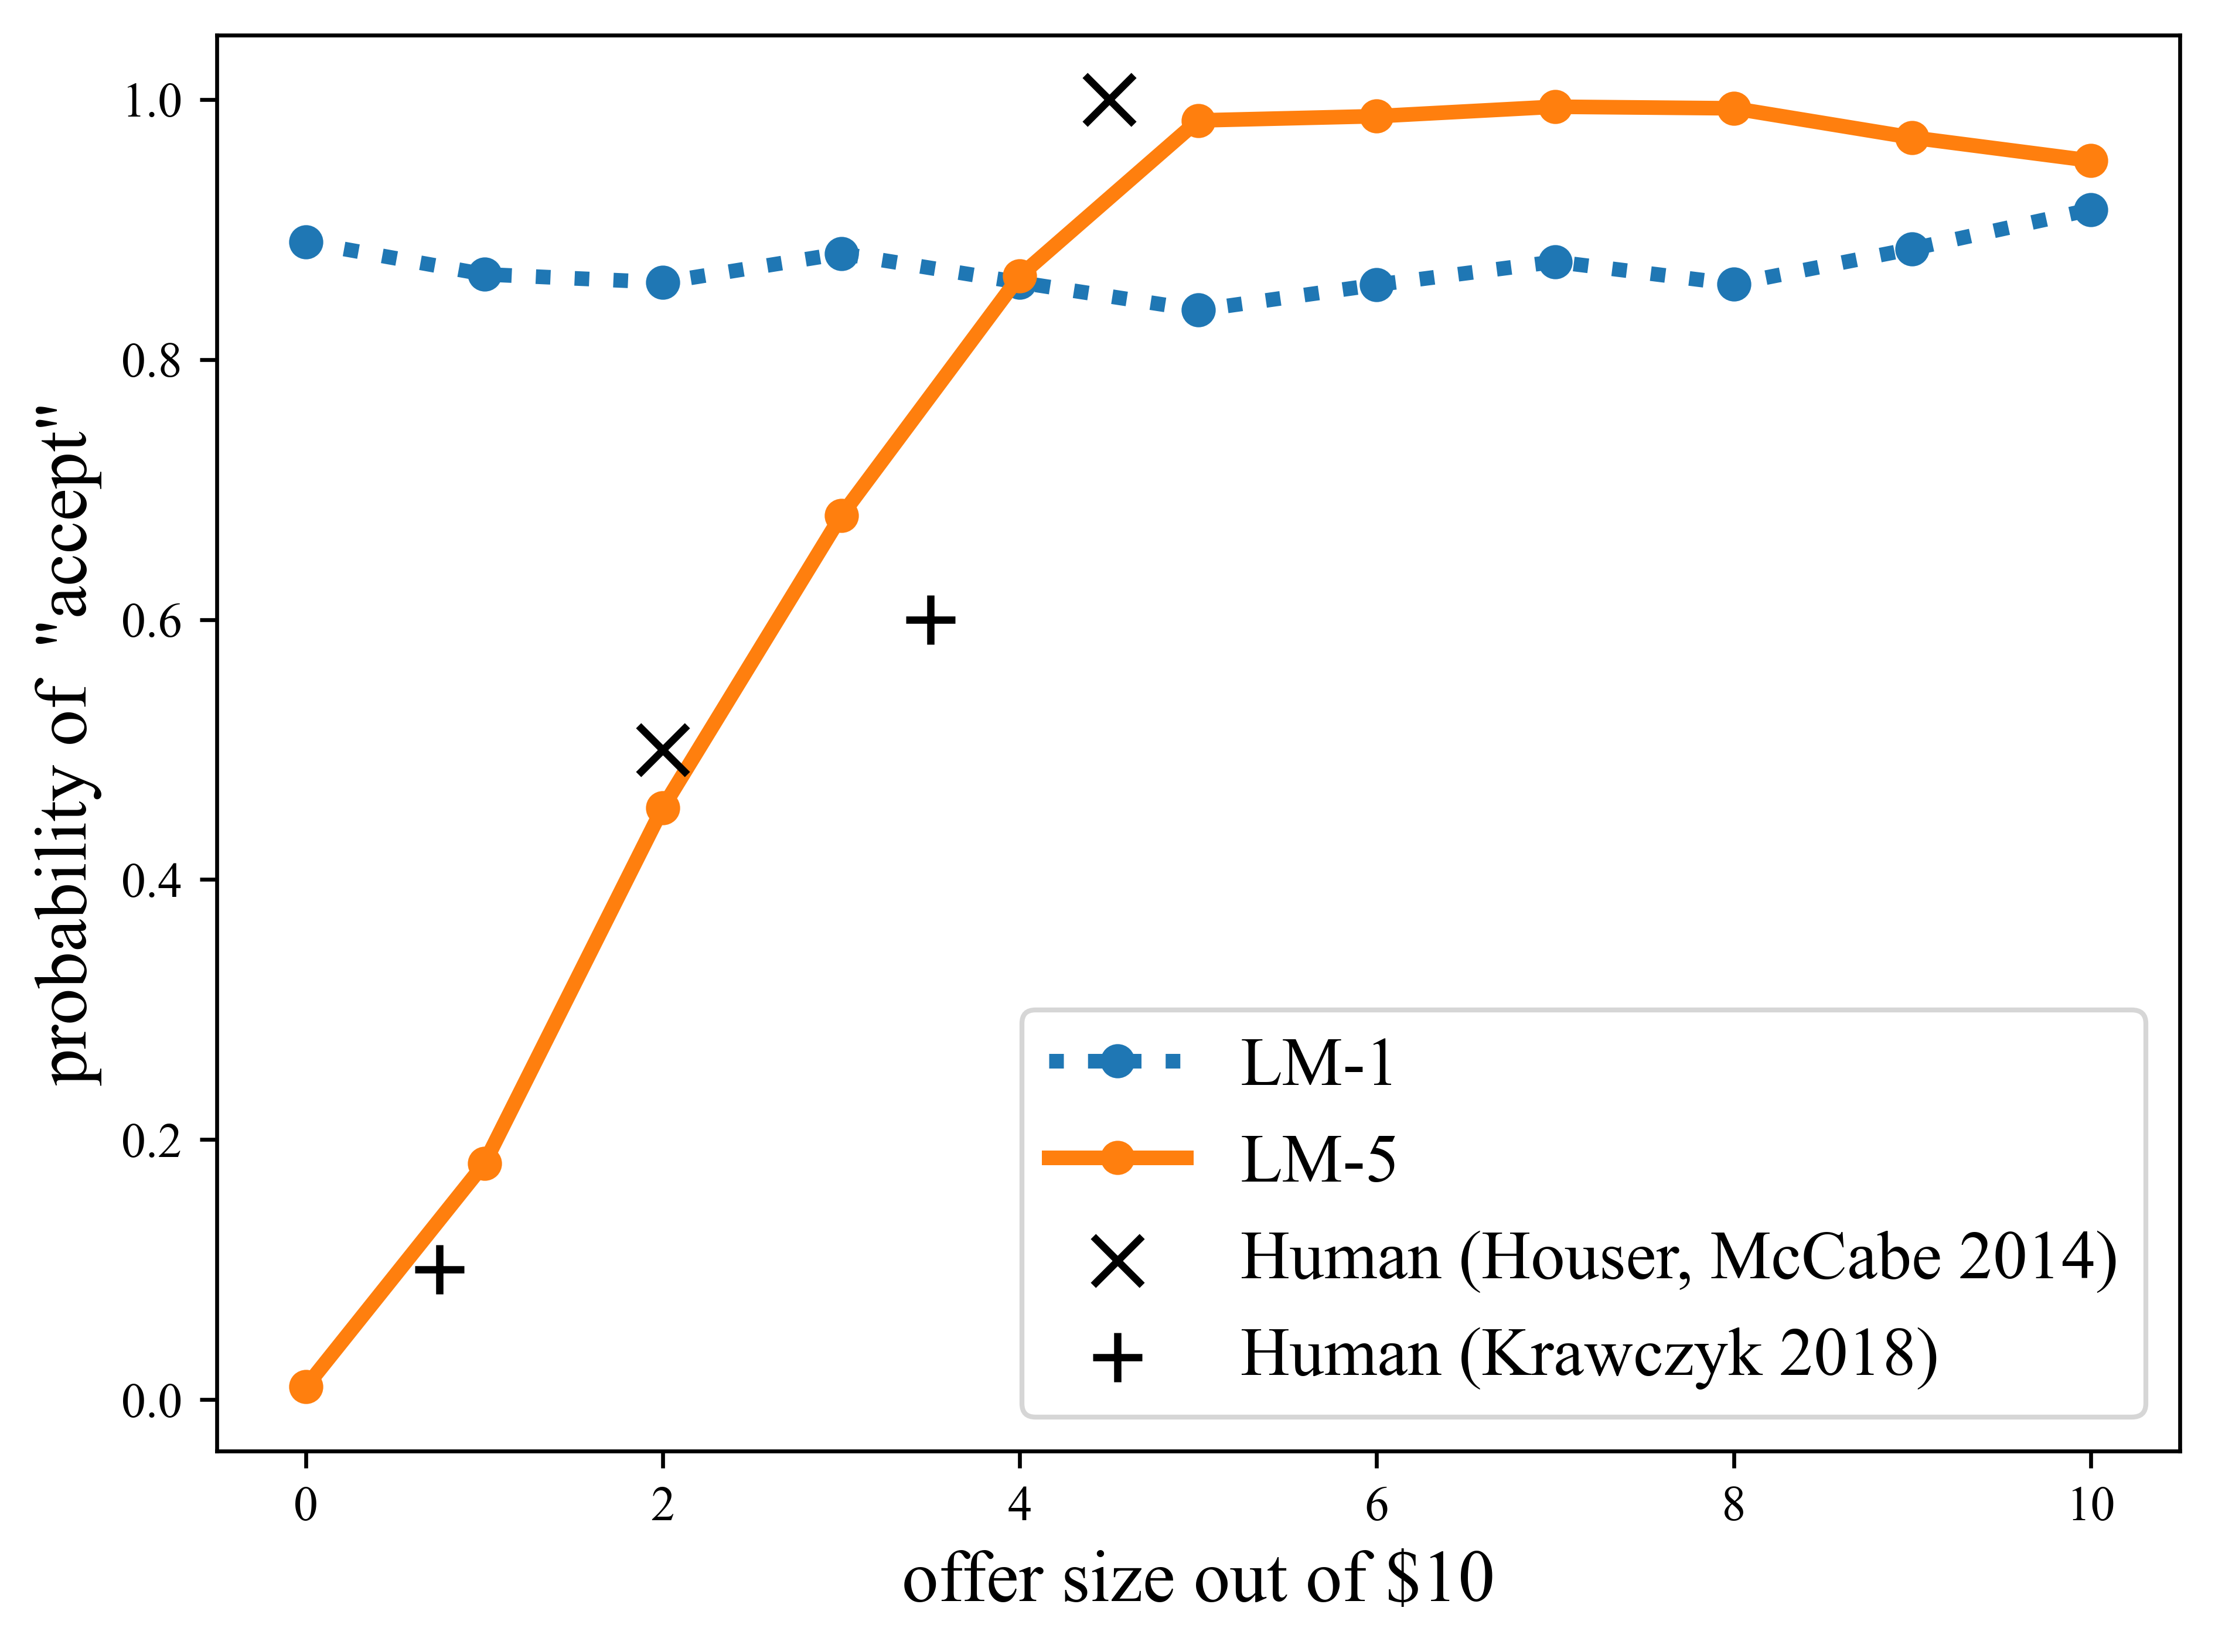

In [39]:
def plot_fig_ug_ada_dav():
    # Human (Houser, McCabe 2014)
    human_houser_offer = [2, 4.5]
    human_houser_p_accept = [0.5, 1.0]

    # Human (Krawczyk 2018)
    human_krawczyk_offer = [3.5, 0.75]
    human_krawczyk_p_accept = [0.6, 0.1]

    fig, ax = plt.subplots(dpi=600)

    # plot average p(accept) - ada
    dict_df_results["text-ada-001"][
        ["offer", "p(accept)"]
    ].groupby("offer").mean().plot(
        ax=ax, zorder=1,linewidth=3, linestyle='dotted', color="tab:blue", 
        markevery=1, marker='o', markerfacecolor="tab:blue"
    )

    # plot average p(accept) - davinci
    dict_df_results["text-davinci-002"][
        ["offer", "p(accept)"]
    ].groupby("offer").mean().plot(
        ax=ax, zorder=2, linewidth=3, linestyle='solid', color="tab:orange",
        markevery=1, marker='o', markerfacecolor="tab:orange",
    )

    # plot Human (Houser, McCabe 2014)
    ax.scatter(
        x=human_houser_offer, y=human_houser_p_accept, zorder=3,
        color="k", s=100, marker="x"
    )

    # plot Human (Krawczyk 2018)
    ax.scatter(
        x=human_krawczyk_offer, y=human_krawczyk_p_accept, zorder=3,
        color="k", s=100, marker="+"
    )

    # plt.title("Average Rate of Acceptance", fontsize=15)
    plt.ylabel('probability of  "accept"', fontsize=15)
    plt.xlabel("offer size out of $10", fontsize=15)
    plt.legend(["LM-1", "LM-5", "Human (Houser, McCabe 2014)", "Human (Krawczyk 2018)"], fontsize=14)
    plt.savefig(path_to_figures_folder / f"{experiment_descriptor}_fig_ug_ada_dav.png", bbox_inches='tight')

plot_fig_ug_ada_dav()

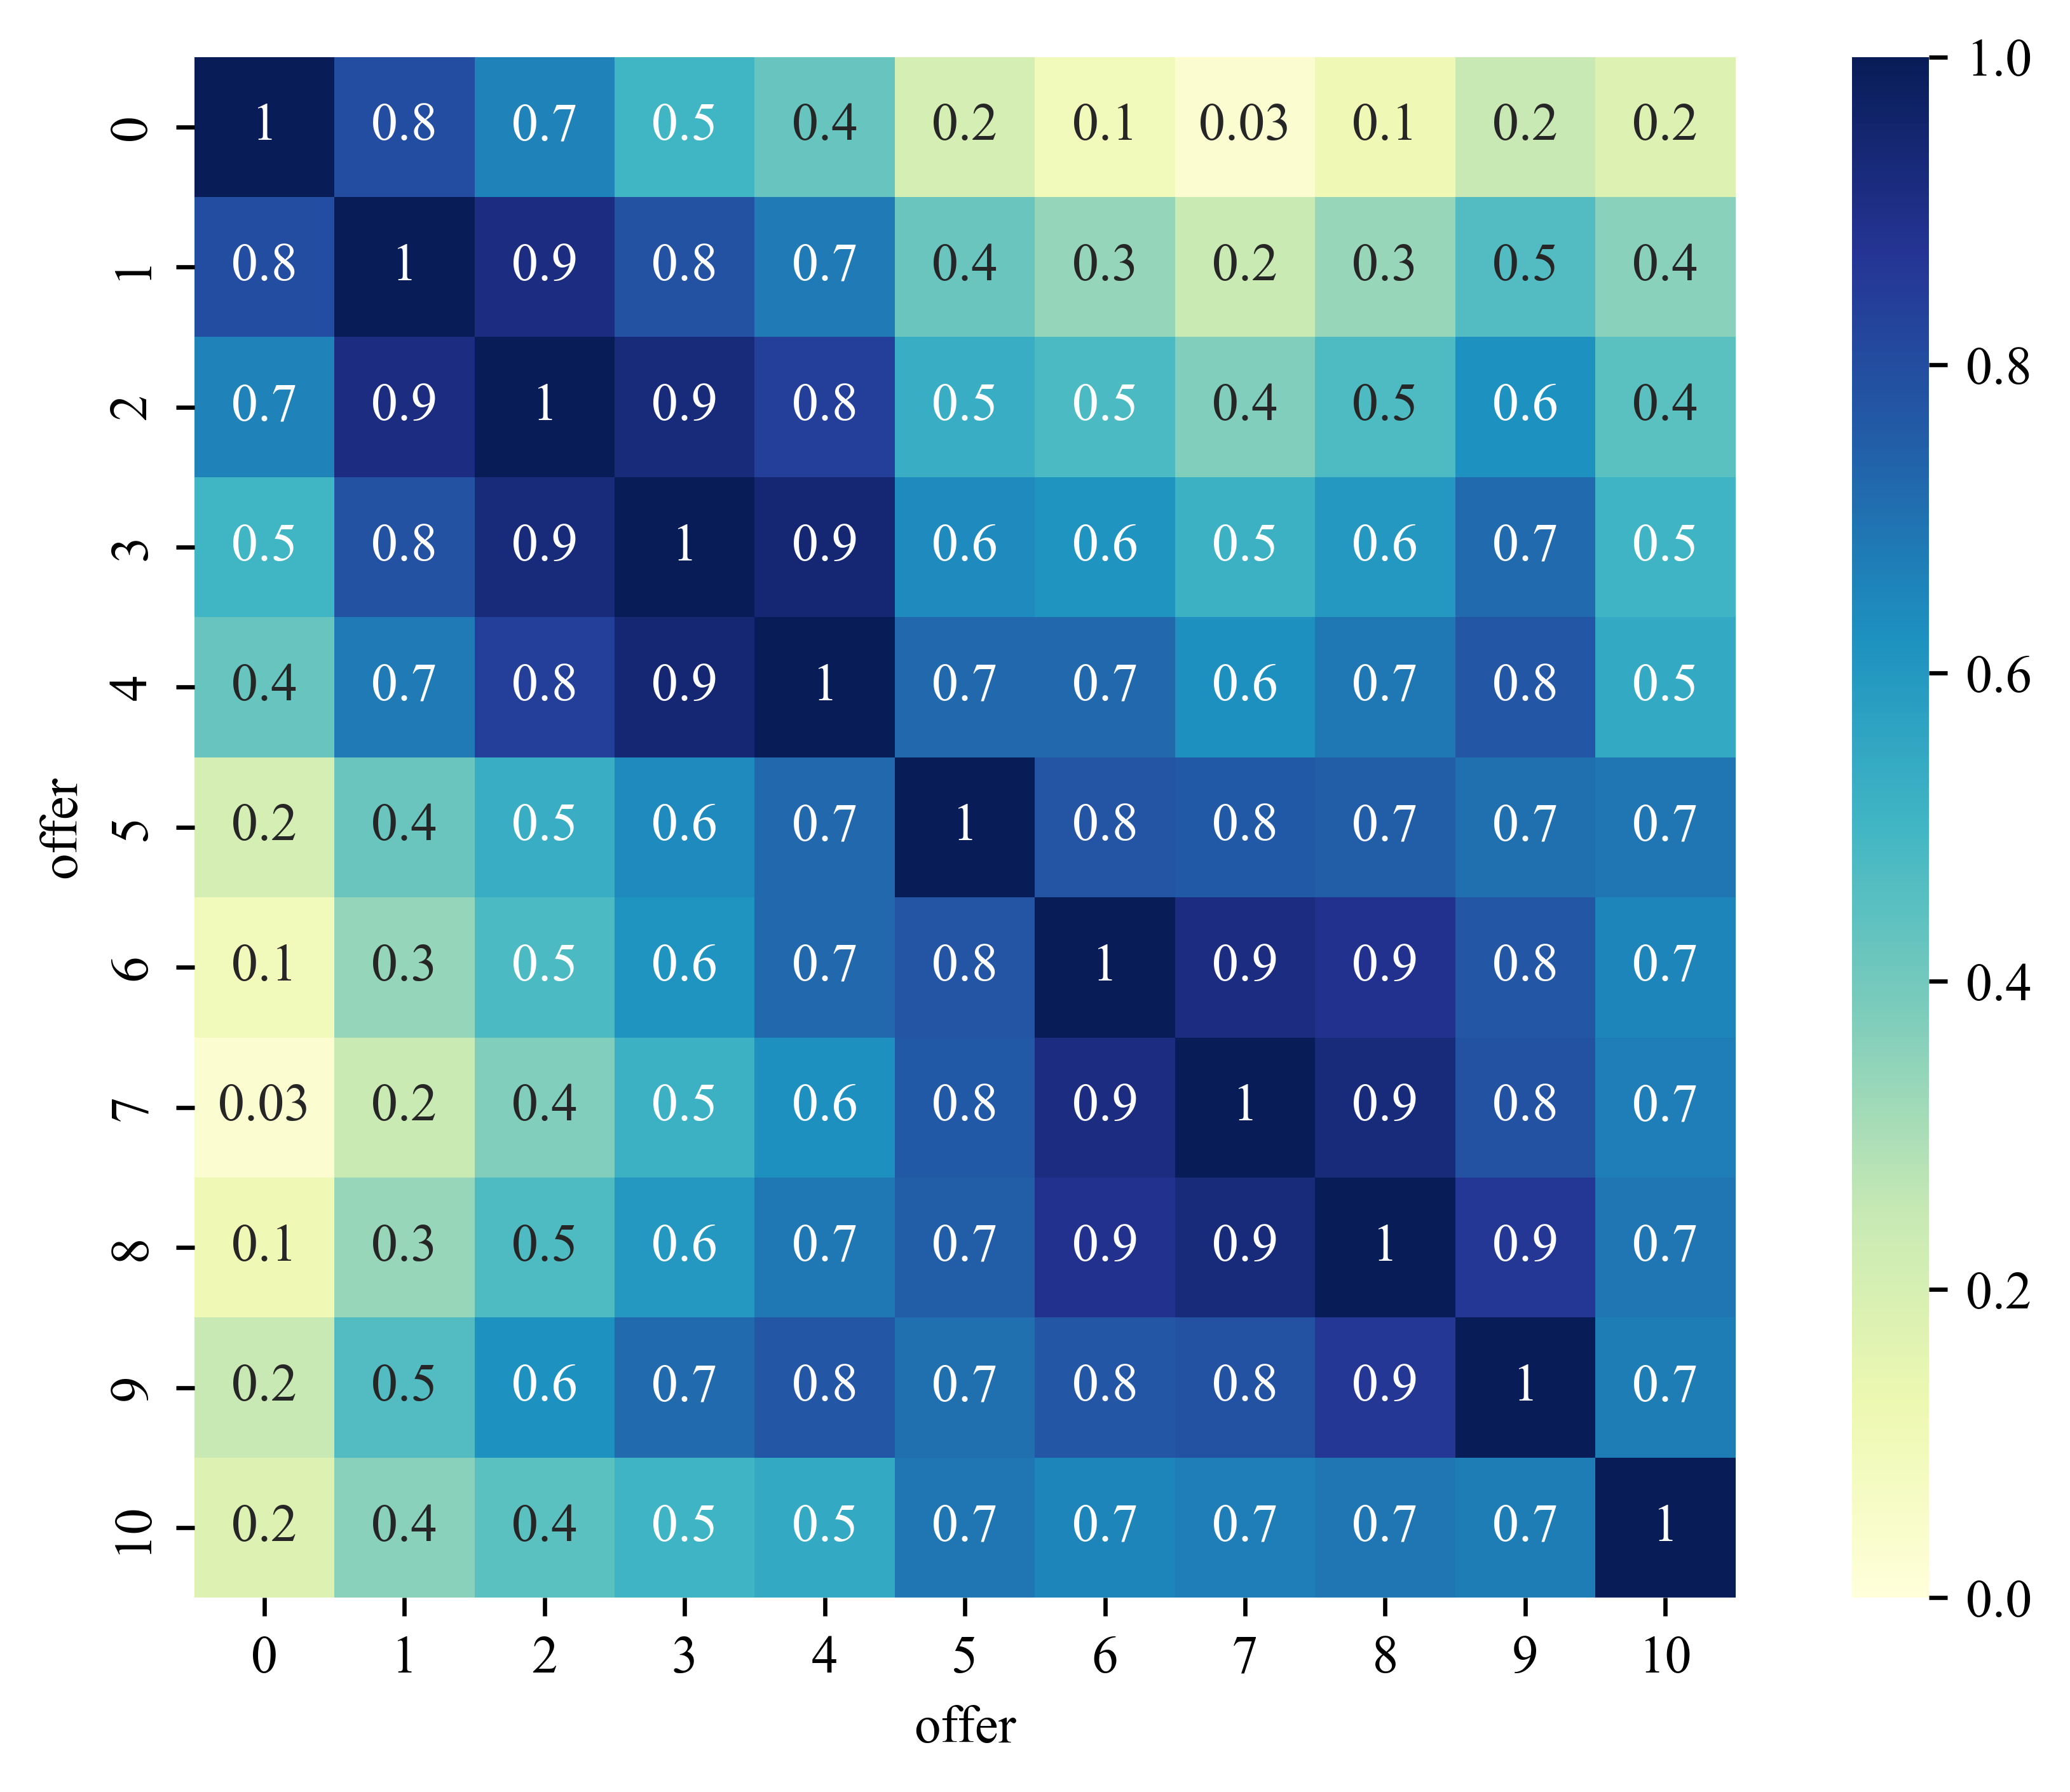

In [40]:
def plot_fig_ug_corr_annot():
    engine = "text-davinci-002"
    table = dict_df_results[engine]
    
    # correlation collapse on name_pair, correlation between offers
    pivot_table = pd.pivot_table(
        table, 
        index=["name_pair"], 
        columns=["offer"], 
        values=["p(accept)"]
    ).corr().reset_index(level=[0], drop=True).droplevel(0, axis=1) 

    fig, ax = plt.subplots(dpi=600)
    sns.heatmap(
        pivot_table, cmap="YlGnBu", square=True, 
        vmin=0, vmax=1, ax=ax, fmt='.1n', annot=True
    )
    fig.savefig(path_to_figures_folder / f'{experiment_descriptor}_fig_ug_corr_annot.png', dpi=600)

plot_fig_ug_corr_annot()

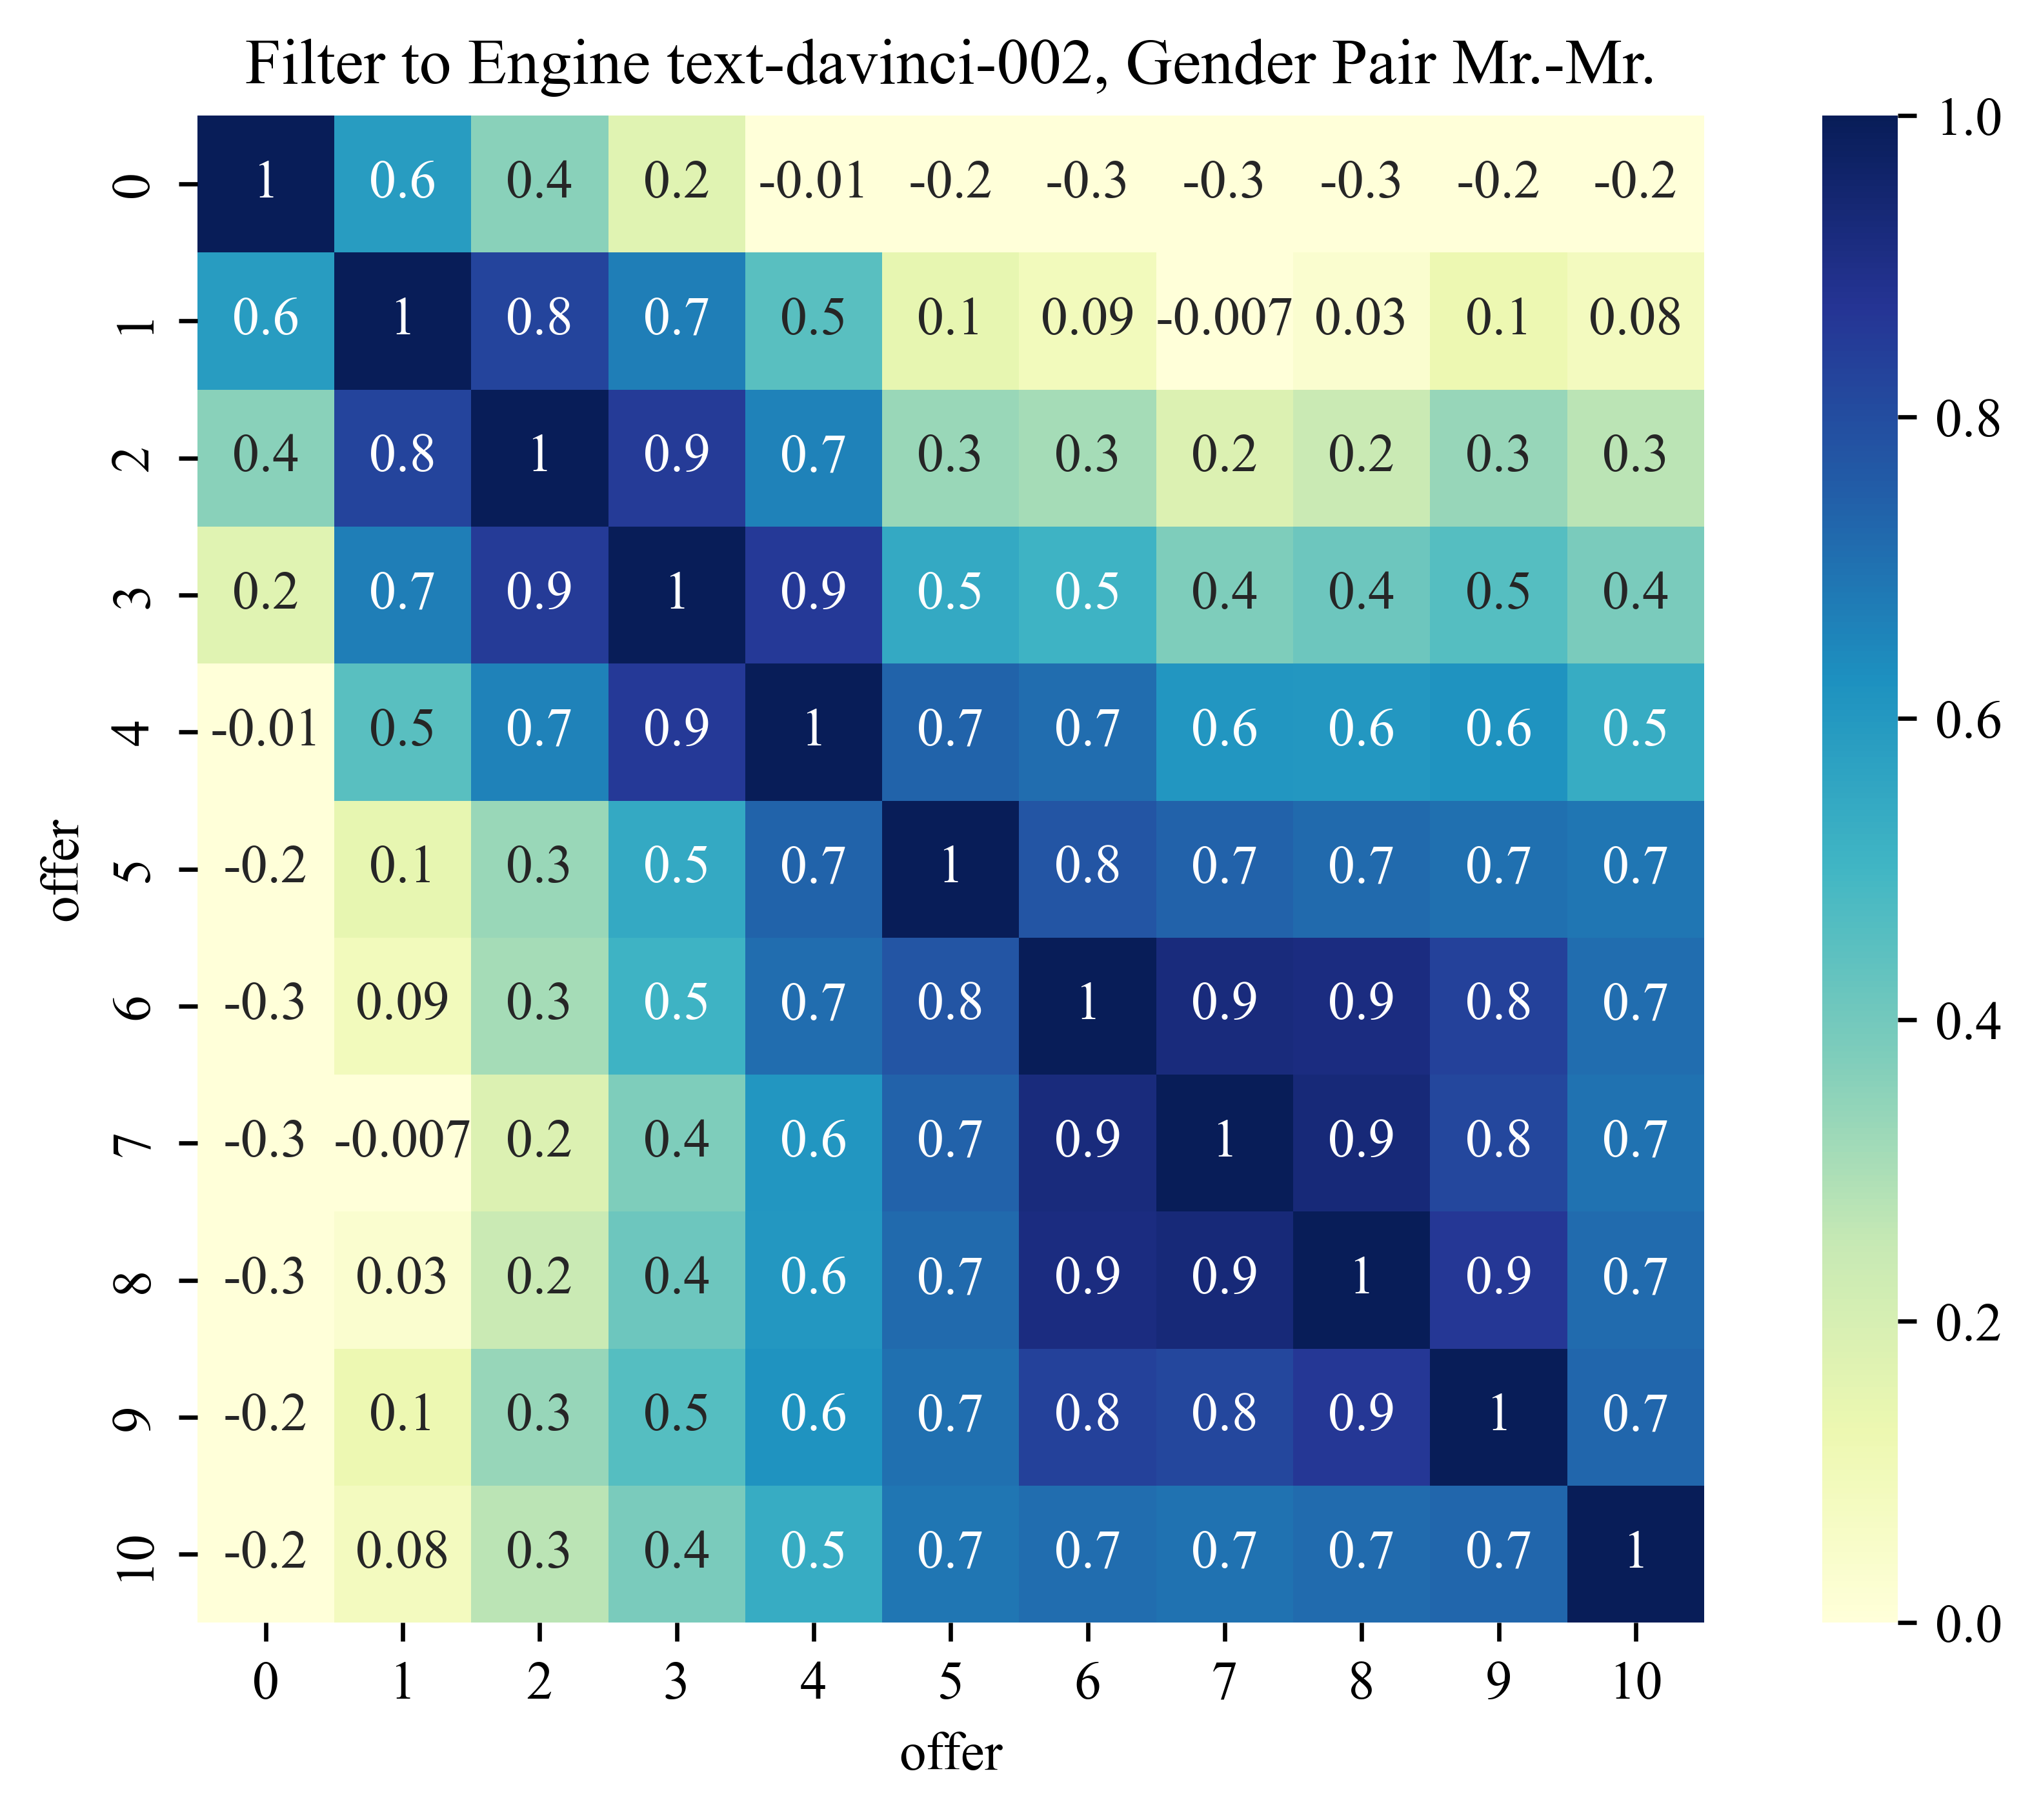

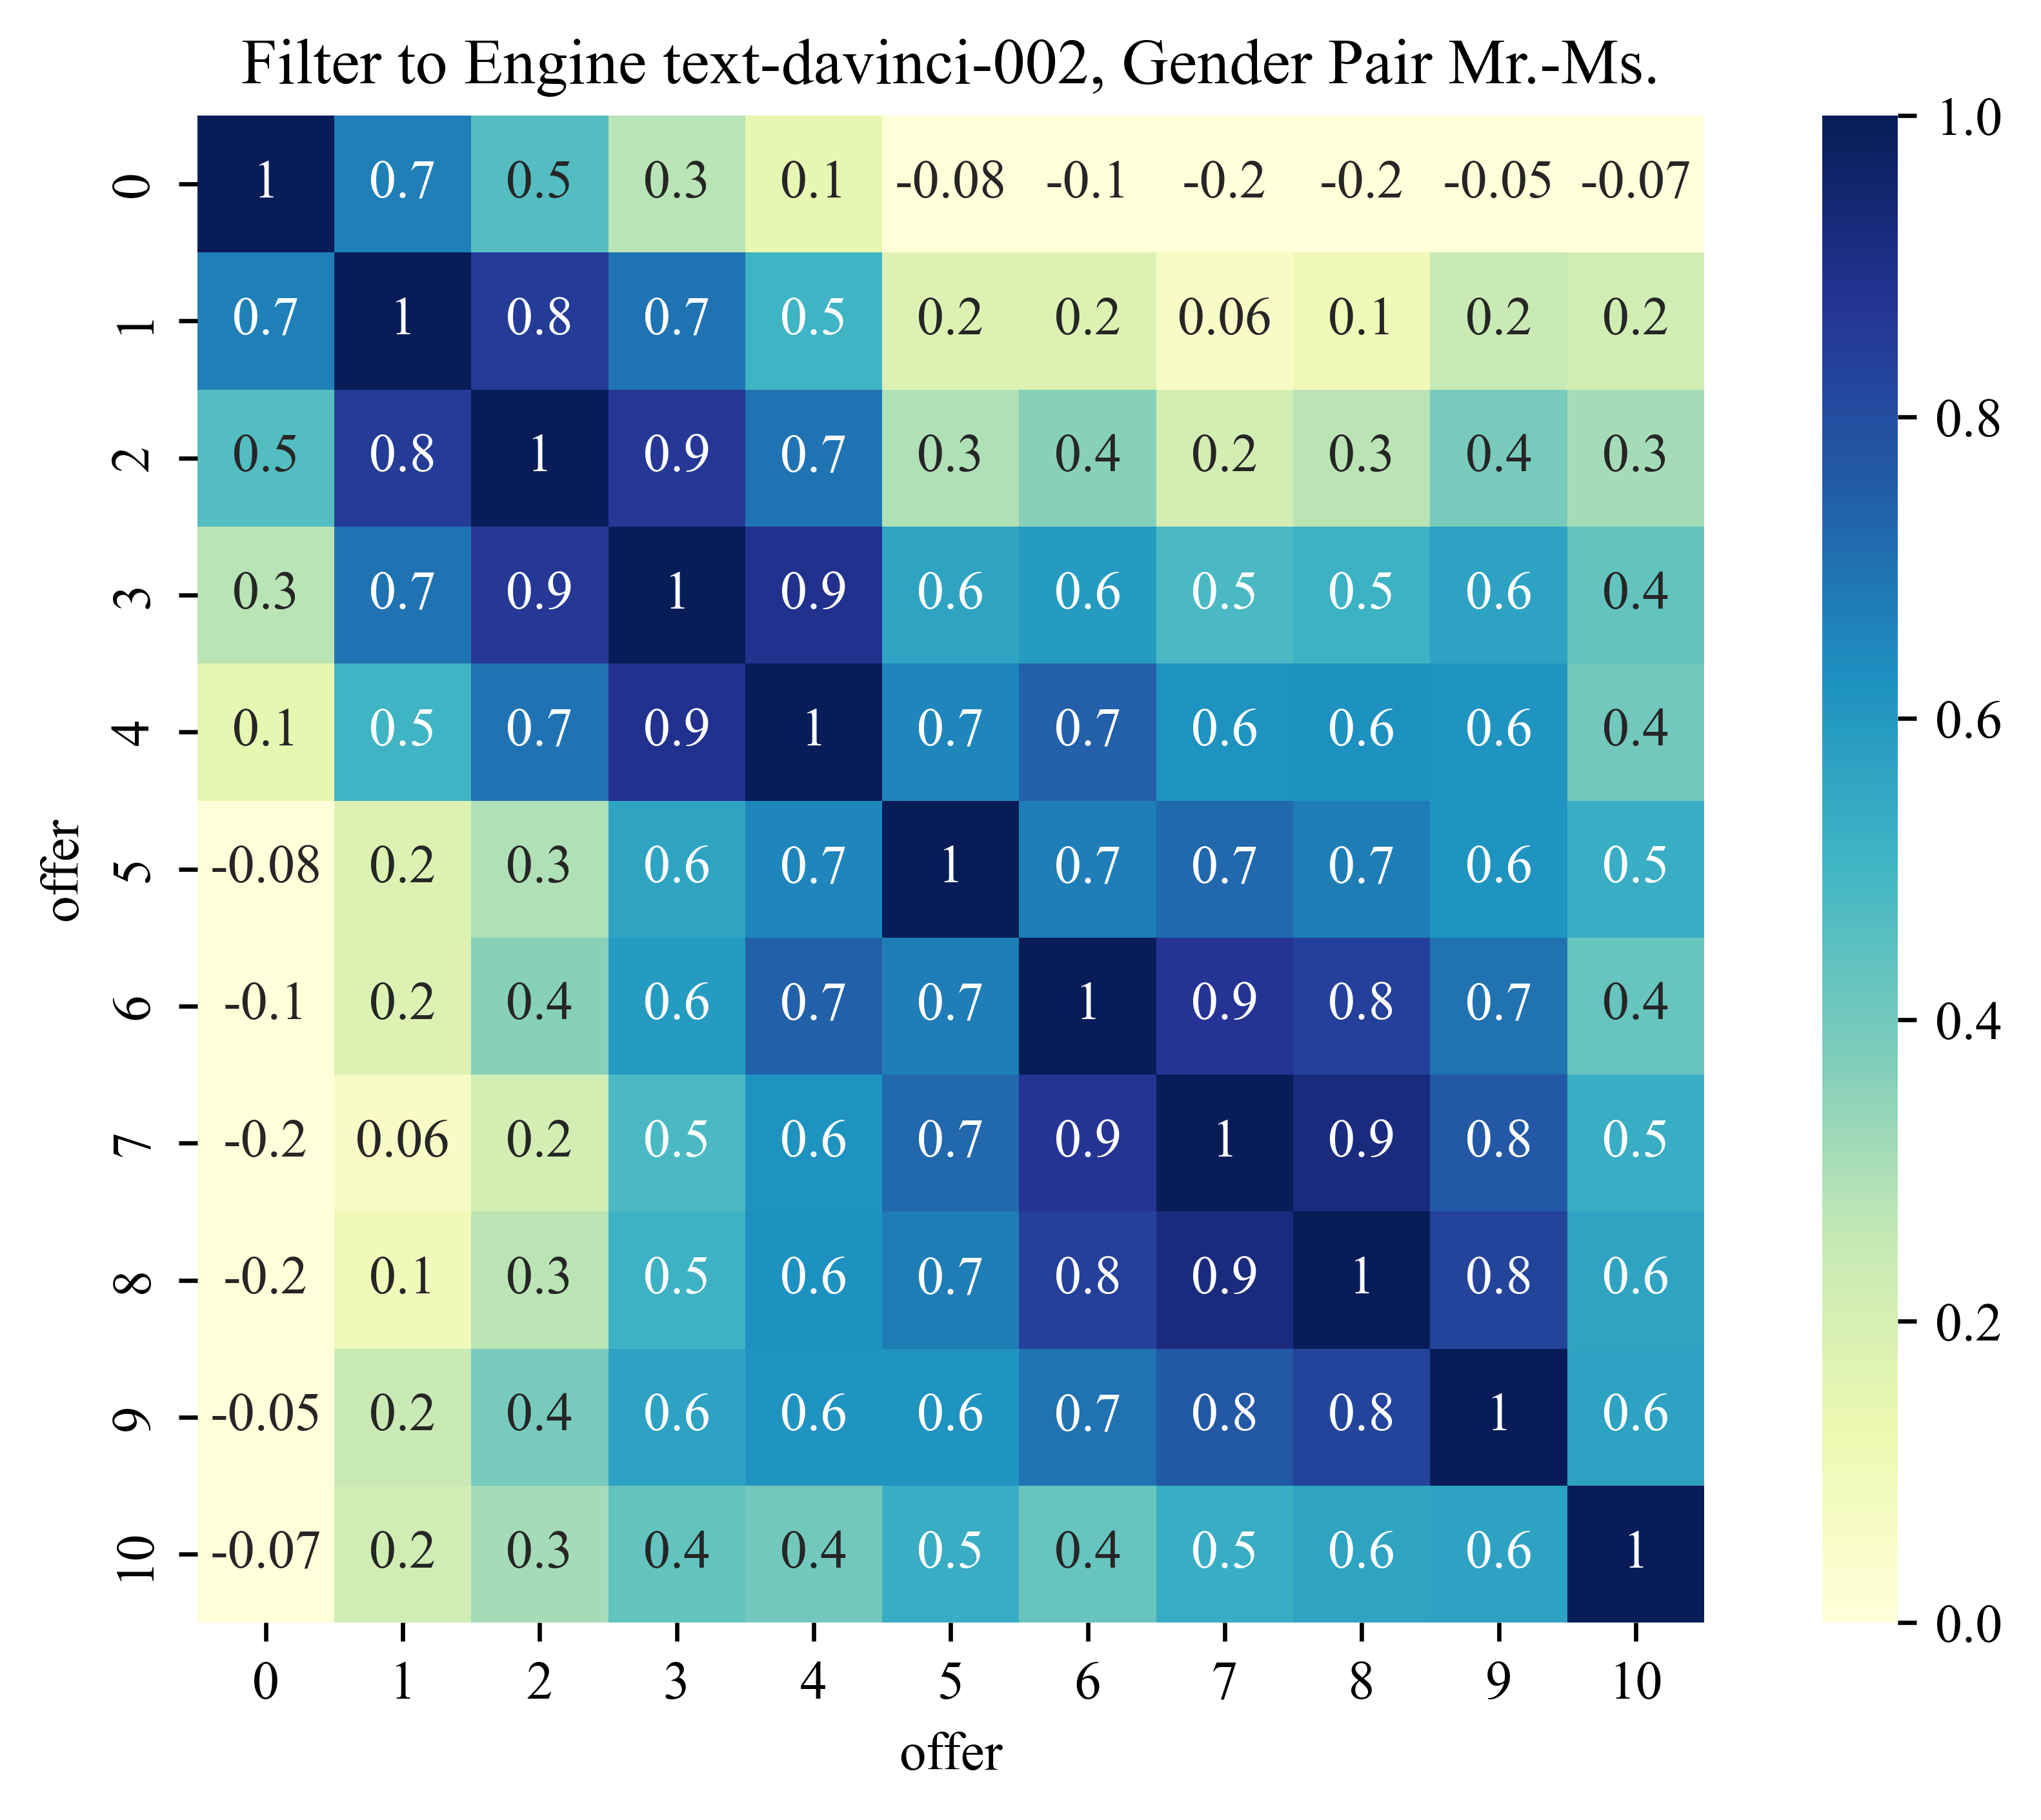

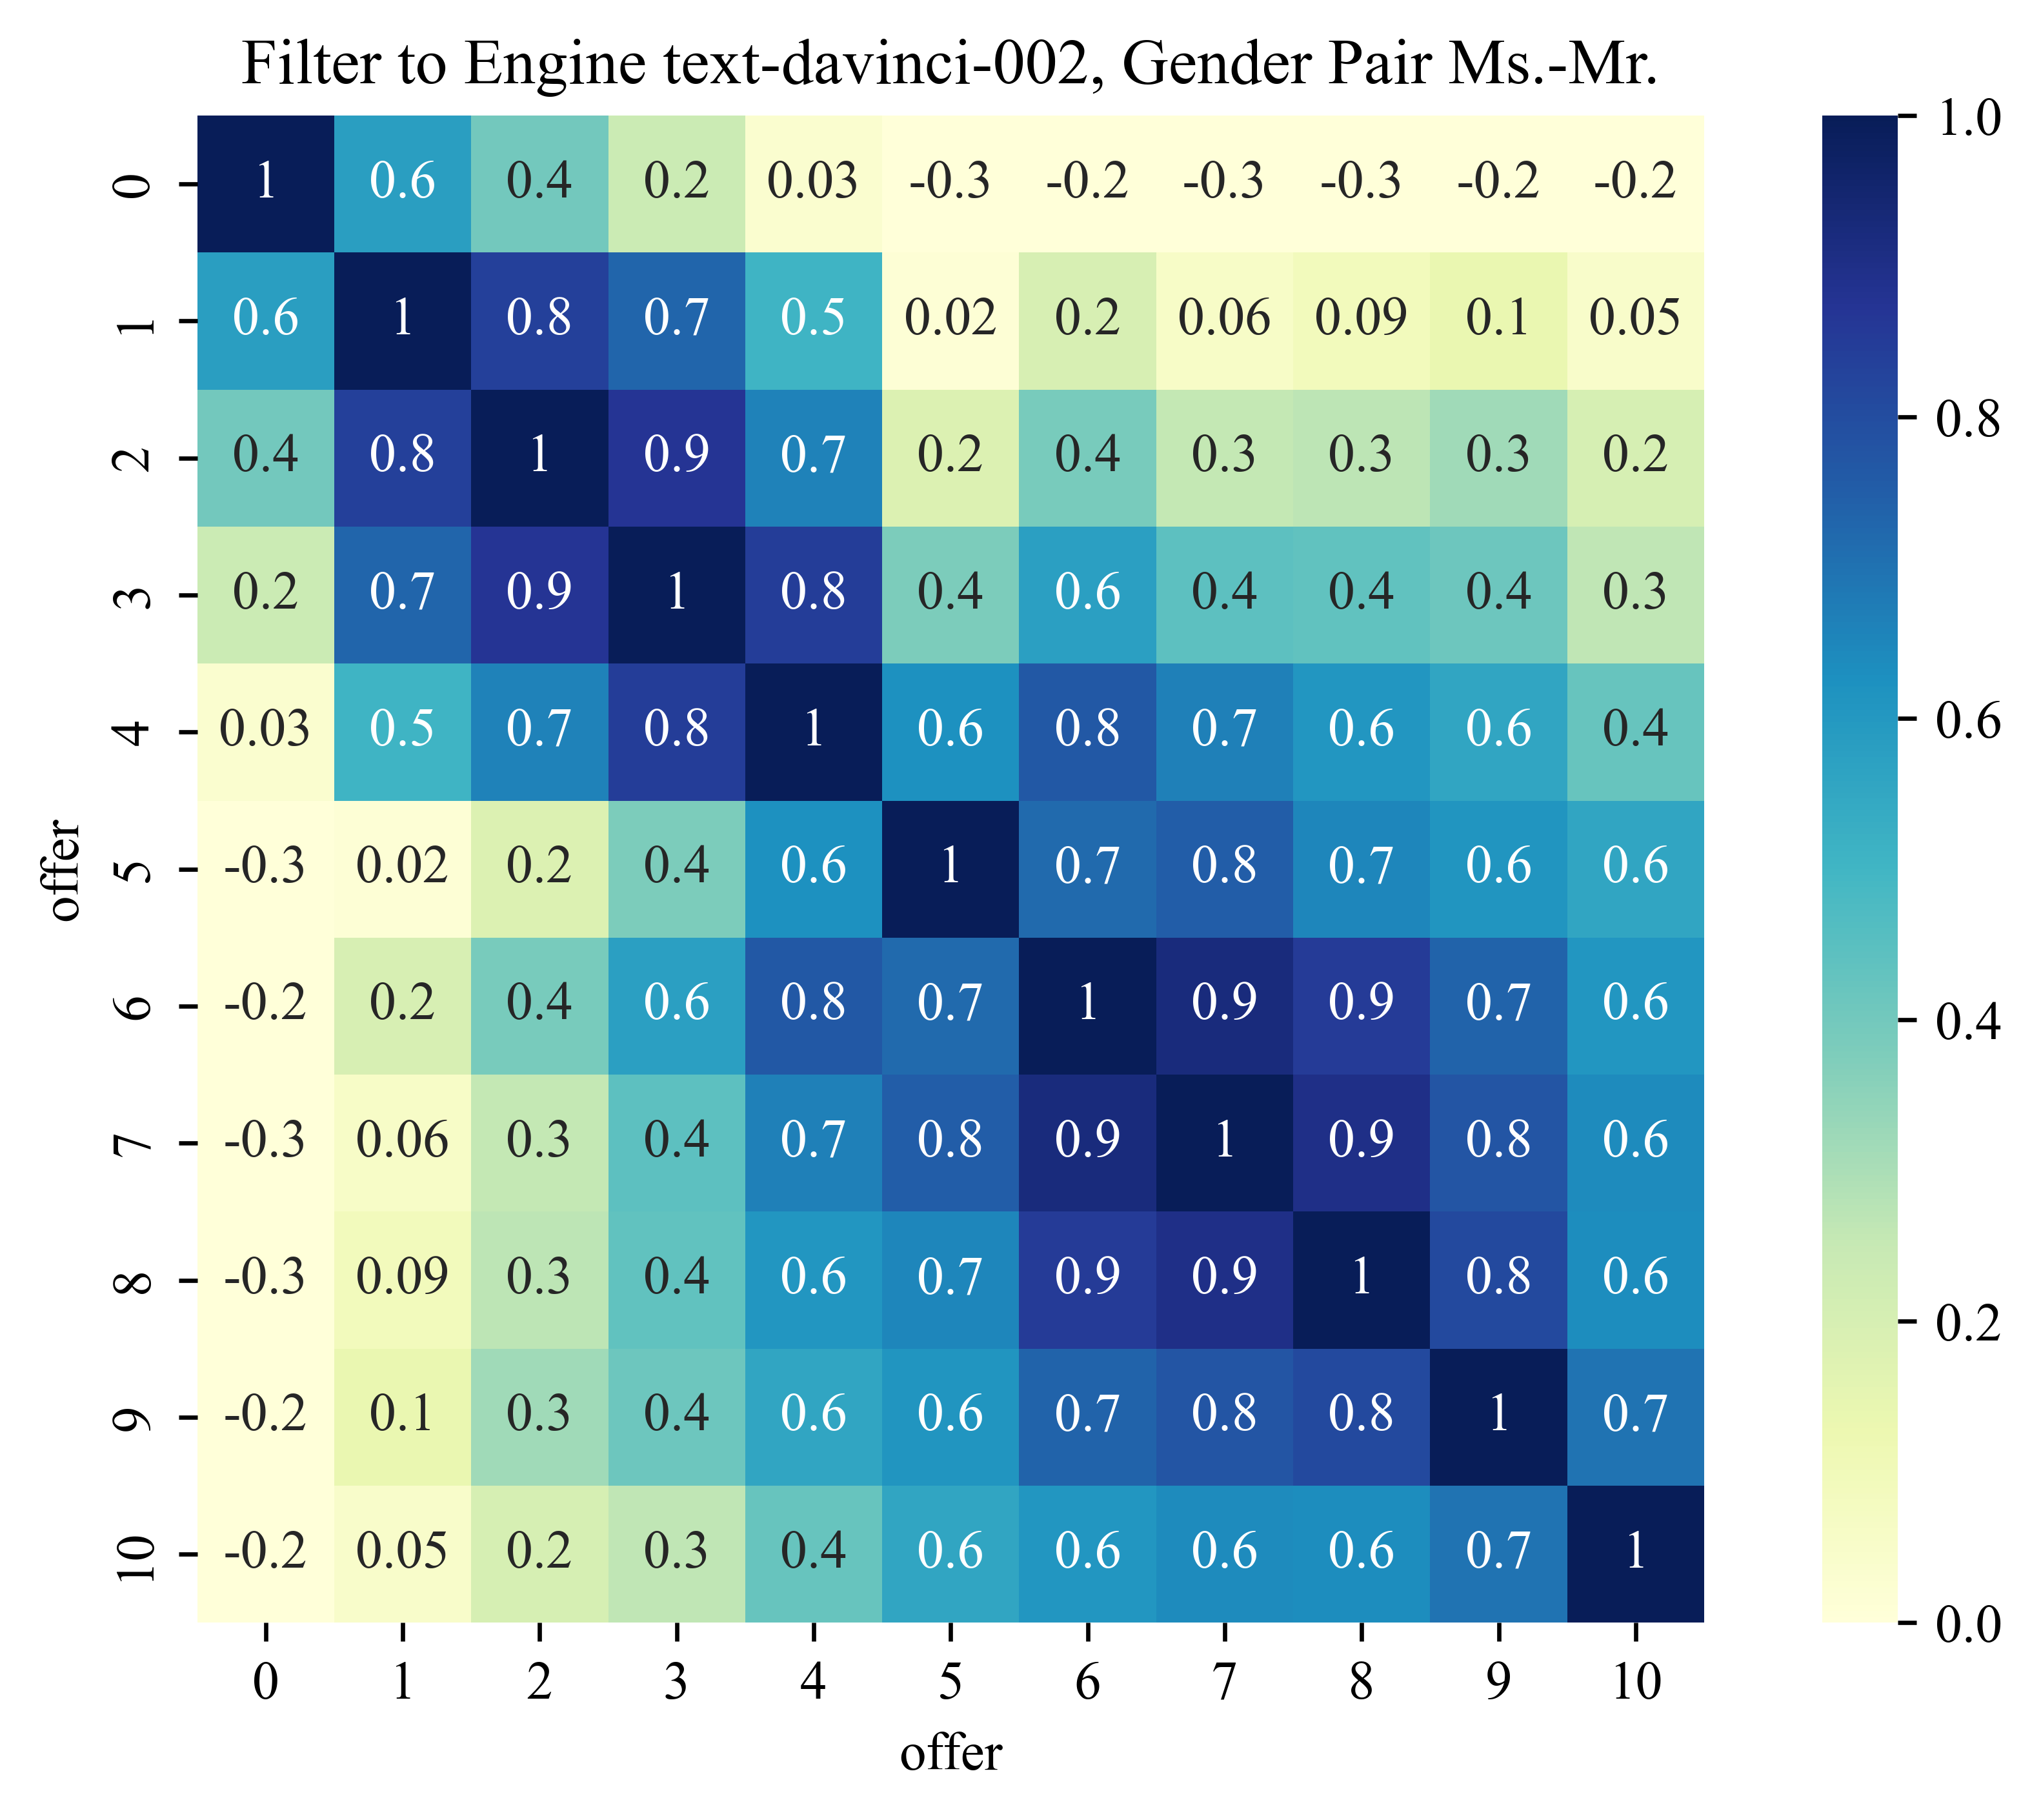

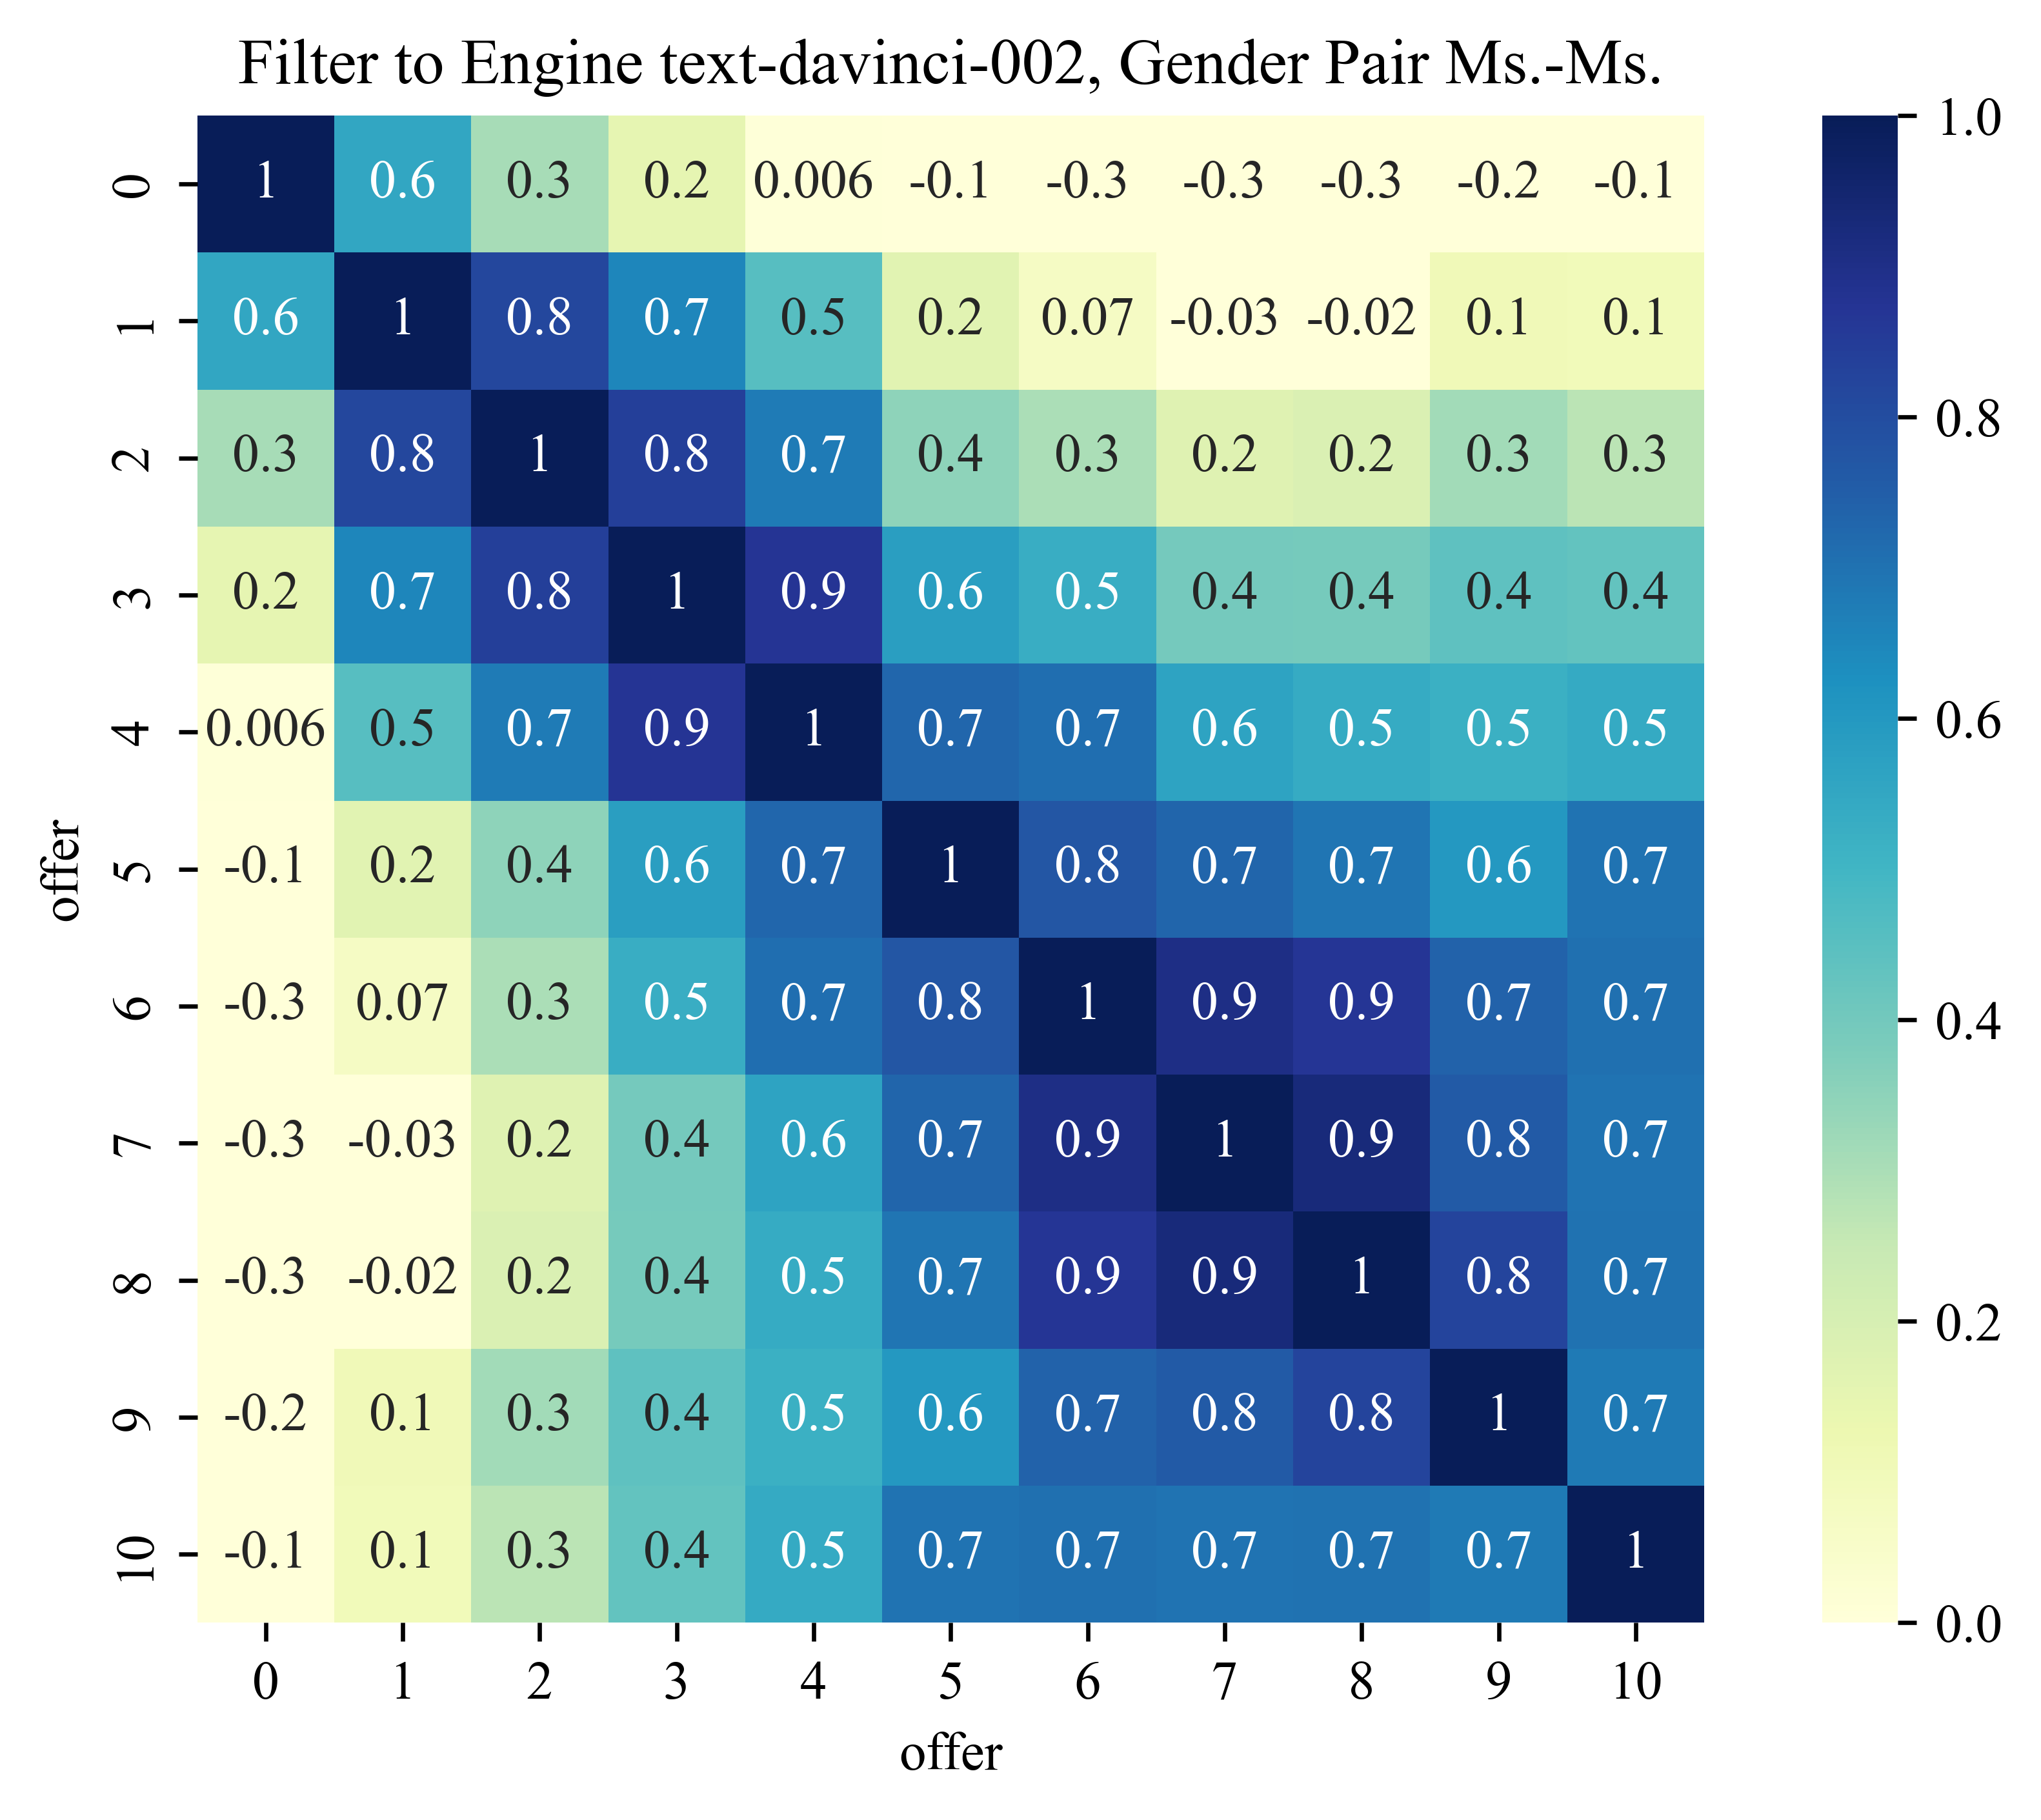

In [41]:
def plot_fig_ug_corr_all_gender_pairs():
    engine = "text-davinci-002"
    table = dict_df_results[engine]

    for gender_pair in list(table["gender_pair"].unique()):
        filtered_table = table[table["gender_pair"] == gender_pair]

        # correlation collapse on name_pair, correlation between offers
        filtered_pivot_table = pd.pivot_table(
            filtered_table, 
            index=["name_pair"], 
            columns=["offer"], 
            values=["p(accept)"]
        ).corr().reset_index(level=[0], drop=True).droplevel(0, axis=1) 

        fig, ax = plt.subplots(dpi=600)
        plt.title(f"Filter to Engine {engine}, Gender Pair {gender_pair}")
        sns.heatmap(
            filtered_pivot_table, cmap="YlGnBu", square=True, 
            vmin=0, vmax=1, ax=ax, fmt='.1n', annot=True
        )
        fig.savefig(
            path_to_figures_folder / f'{experiment_descriptor}_fig_ug_corr_{engine}_{gender_pair.replace(".", "")}.png', 
            dpi=600
        )

plot_fig_ug_corr_all_gender_pairs()

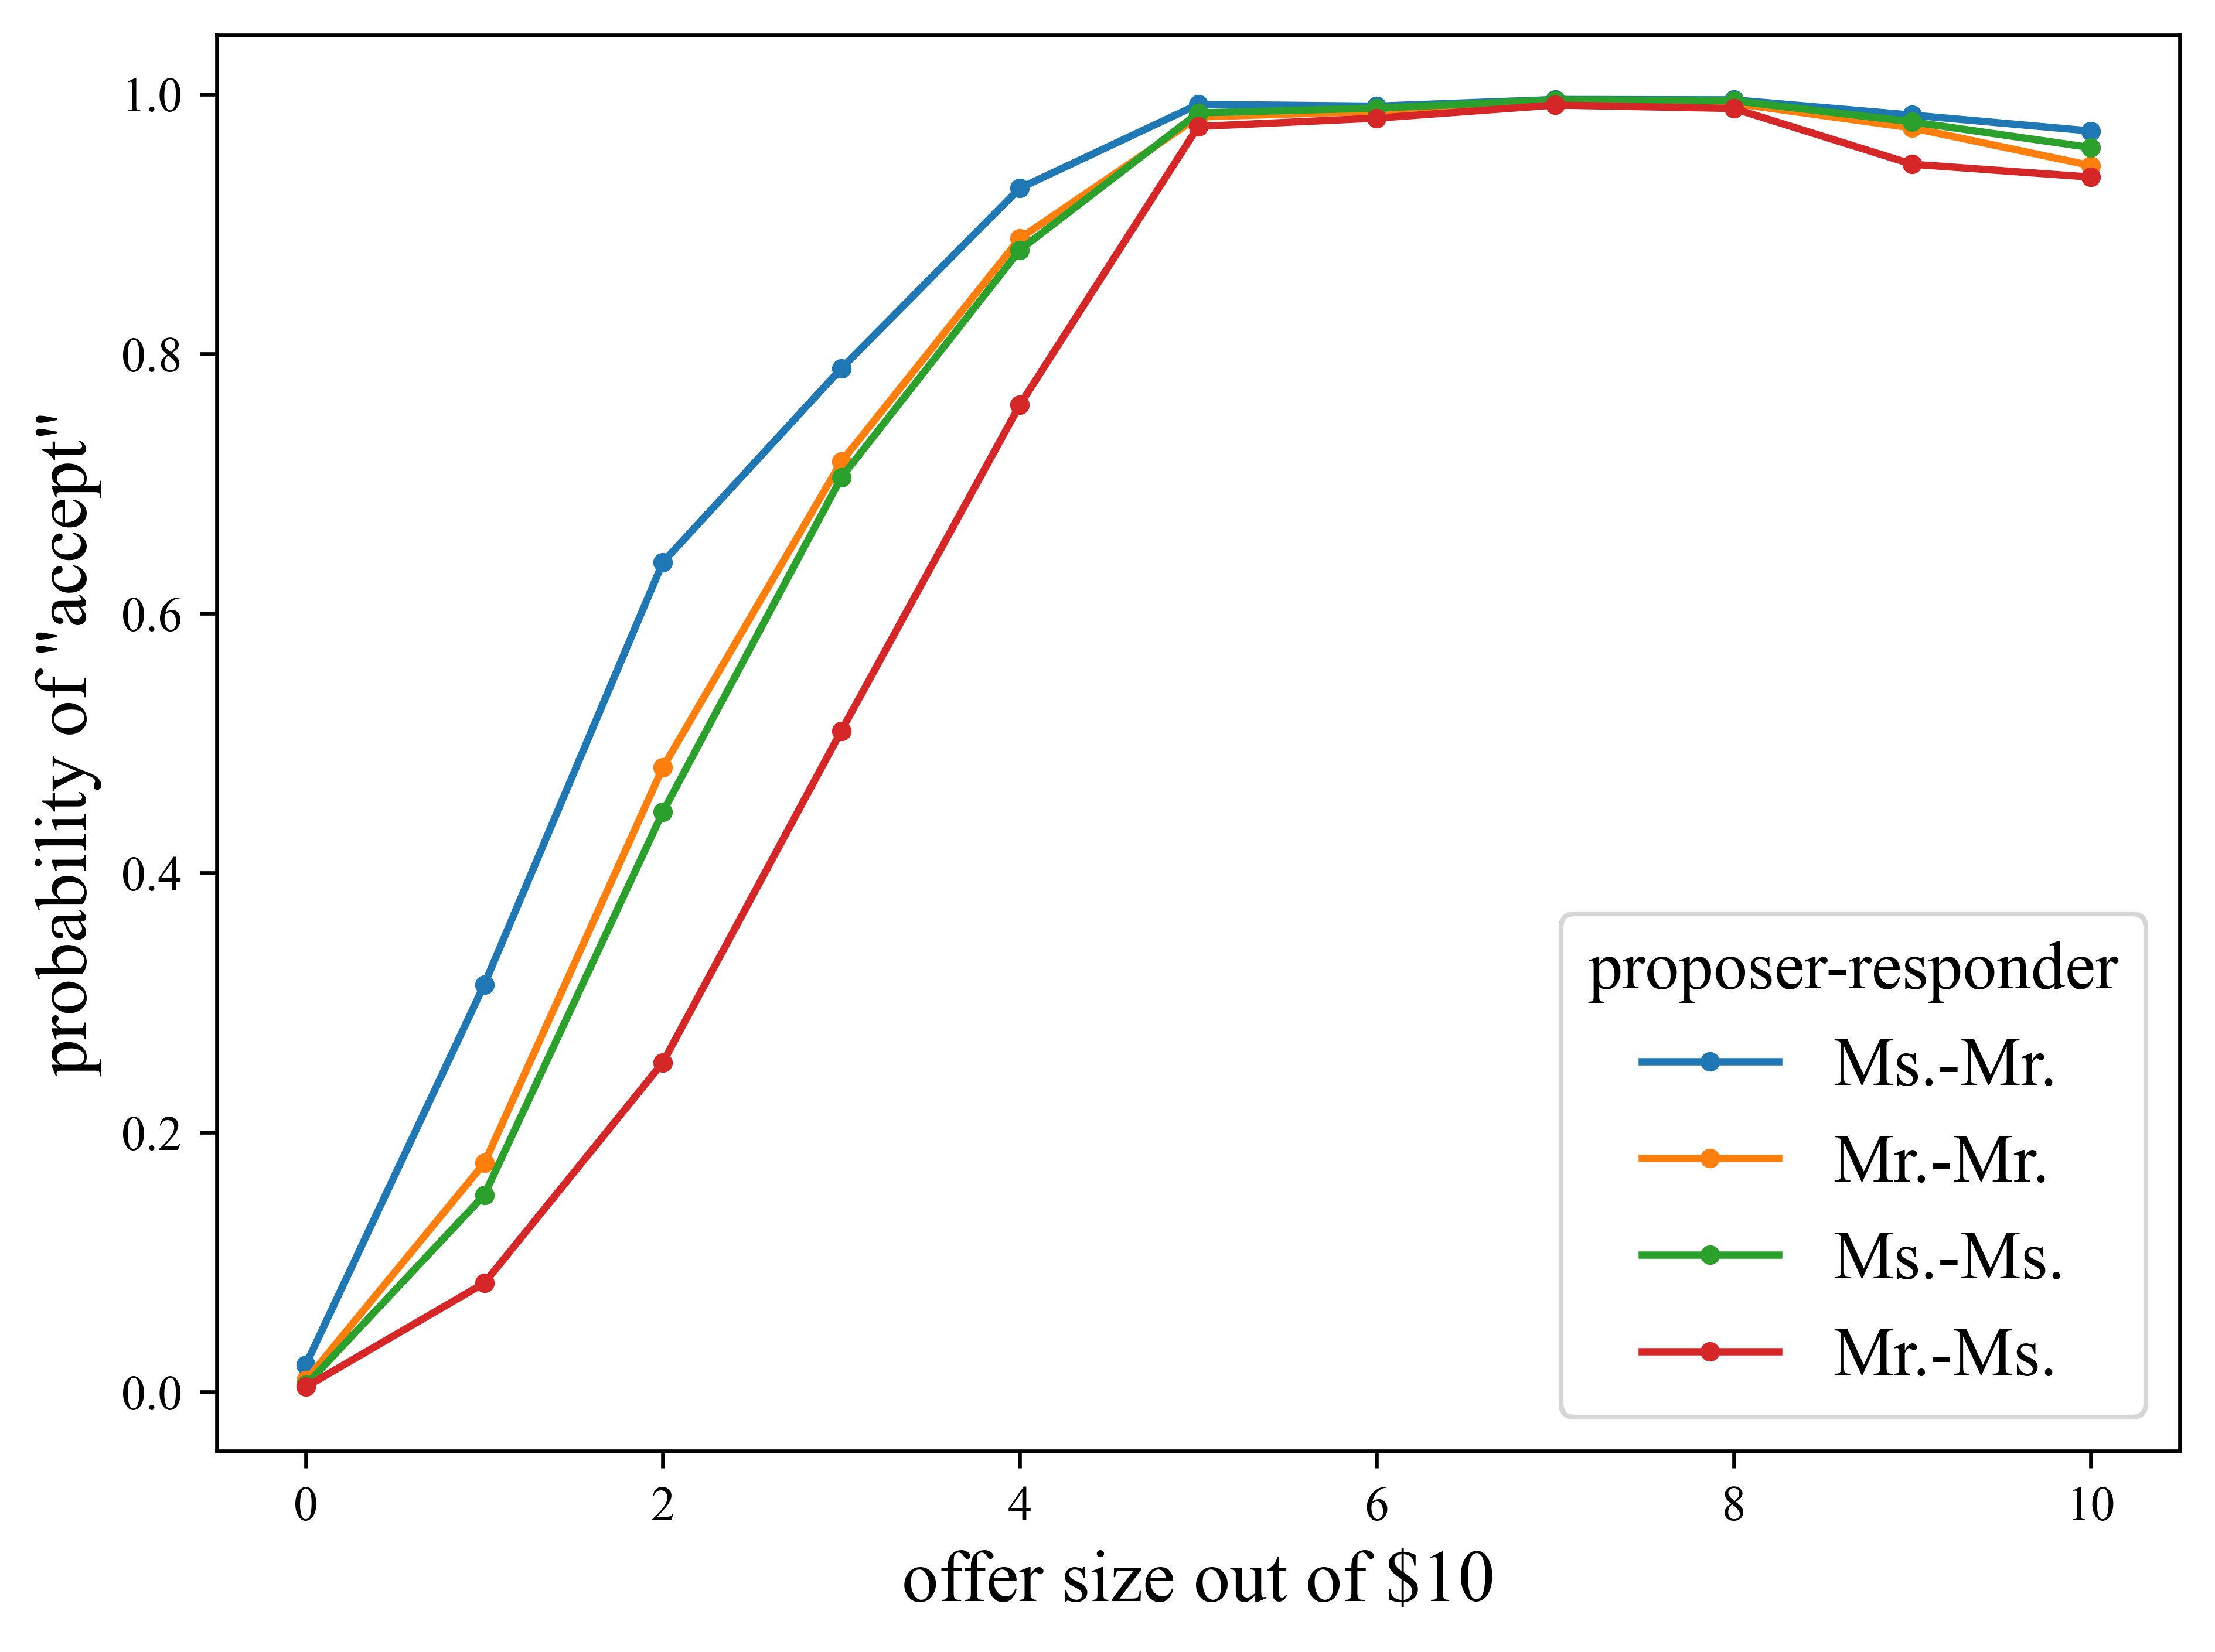

In [42]:
def plot_fig_ug_gender1():
    engine = "text-davinci-002"
    table = dict_df_results[engine]

    # Ordered to align with colors blue, orange, green, red.
    ordered_gender_pairs = ['Ms.-Mr.', 'Mr.-Mr.', 'Ms.-Ms.', 'Mr.-Ms.']

    fig, ax = plt.subplots(dpi=600)

    for gender_pair in ordered_gender_pairs:
        table[
            table["gender_pair"] == gender_pair
        ].groupby(["offer"])[["p(accept)"]].mean().plot(
            ax=ax,
            title="p(accept) by gender pair", 
            markevery=1, 
            marker='.'
        )

    # plt.title("Average Rate of Acceptance By Gender Pairing", fontsize=15)
    plt.title("", fontsize=15)
    plt.ylabel('probability of "accept"', fontsize=15)
    plt.xlabel("offer size out of $10", fontsize=15)
    plt.legend(
        ordered_gender_pairs, loc="lower right", fontsize=14, 
        title="proposer-responder", title_fontsize=14)
    plt.savefig(
        path_to_figures_folder / f"{experiment_descriptor}_fig_ug_gender1.png", 
        bbox_inches='tight'
    )

plot_fig_ug_gender1()

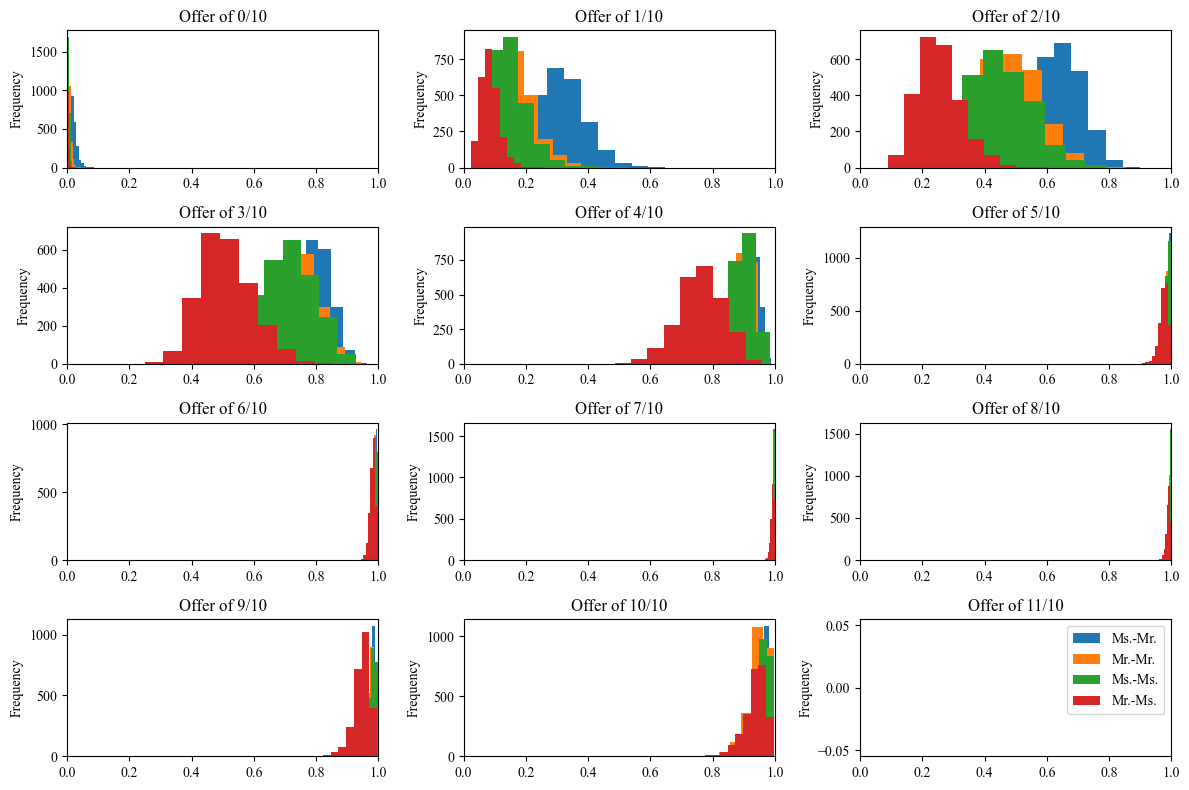

In [43]:
def plot_gender_hist():
    engine = "text-davinci-002"
    table = dict_df_results[engine]

    # Ordered to align with colors blue, orange, green, red.
    ordered_gender_pairs = ['Ms.-Mr.', 'Mr.-Mr.', 'Ms.-Ms.', 'Mr.-Ms.']
    
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,8))
    offer = 0
    for a in axes:
        for ax in a:
            for gp in ordered_gender_pairs:
                table[
                    (table["offer"] == offer) & (table["gender_pair"] == gp)
                ]["p(accept)"].plot(
                    kind="hist", 
                    title=f"Offer of {offer}/10", 
                    ax=ax,
                    xlim=[0, 1],
                    alpha=1
                )
            offer += 1
    ax.legend(ordered_gender_pairs)

plot_gender_hist()

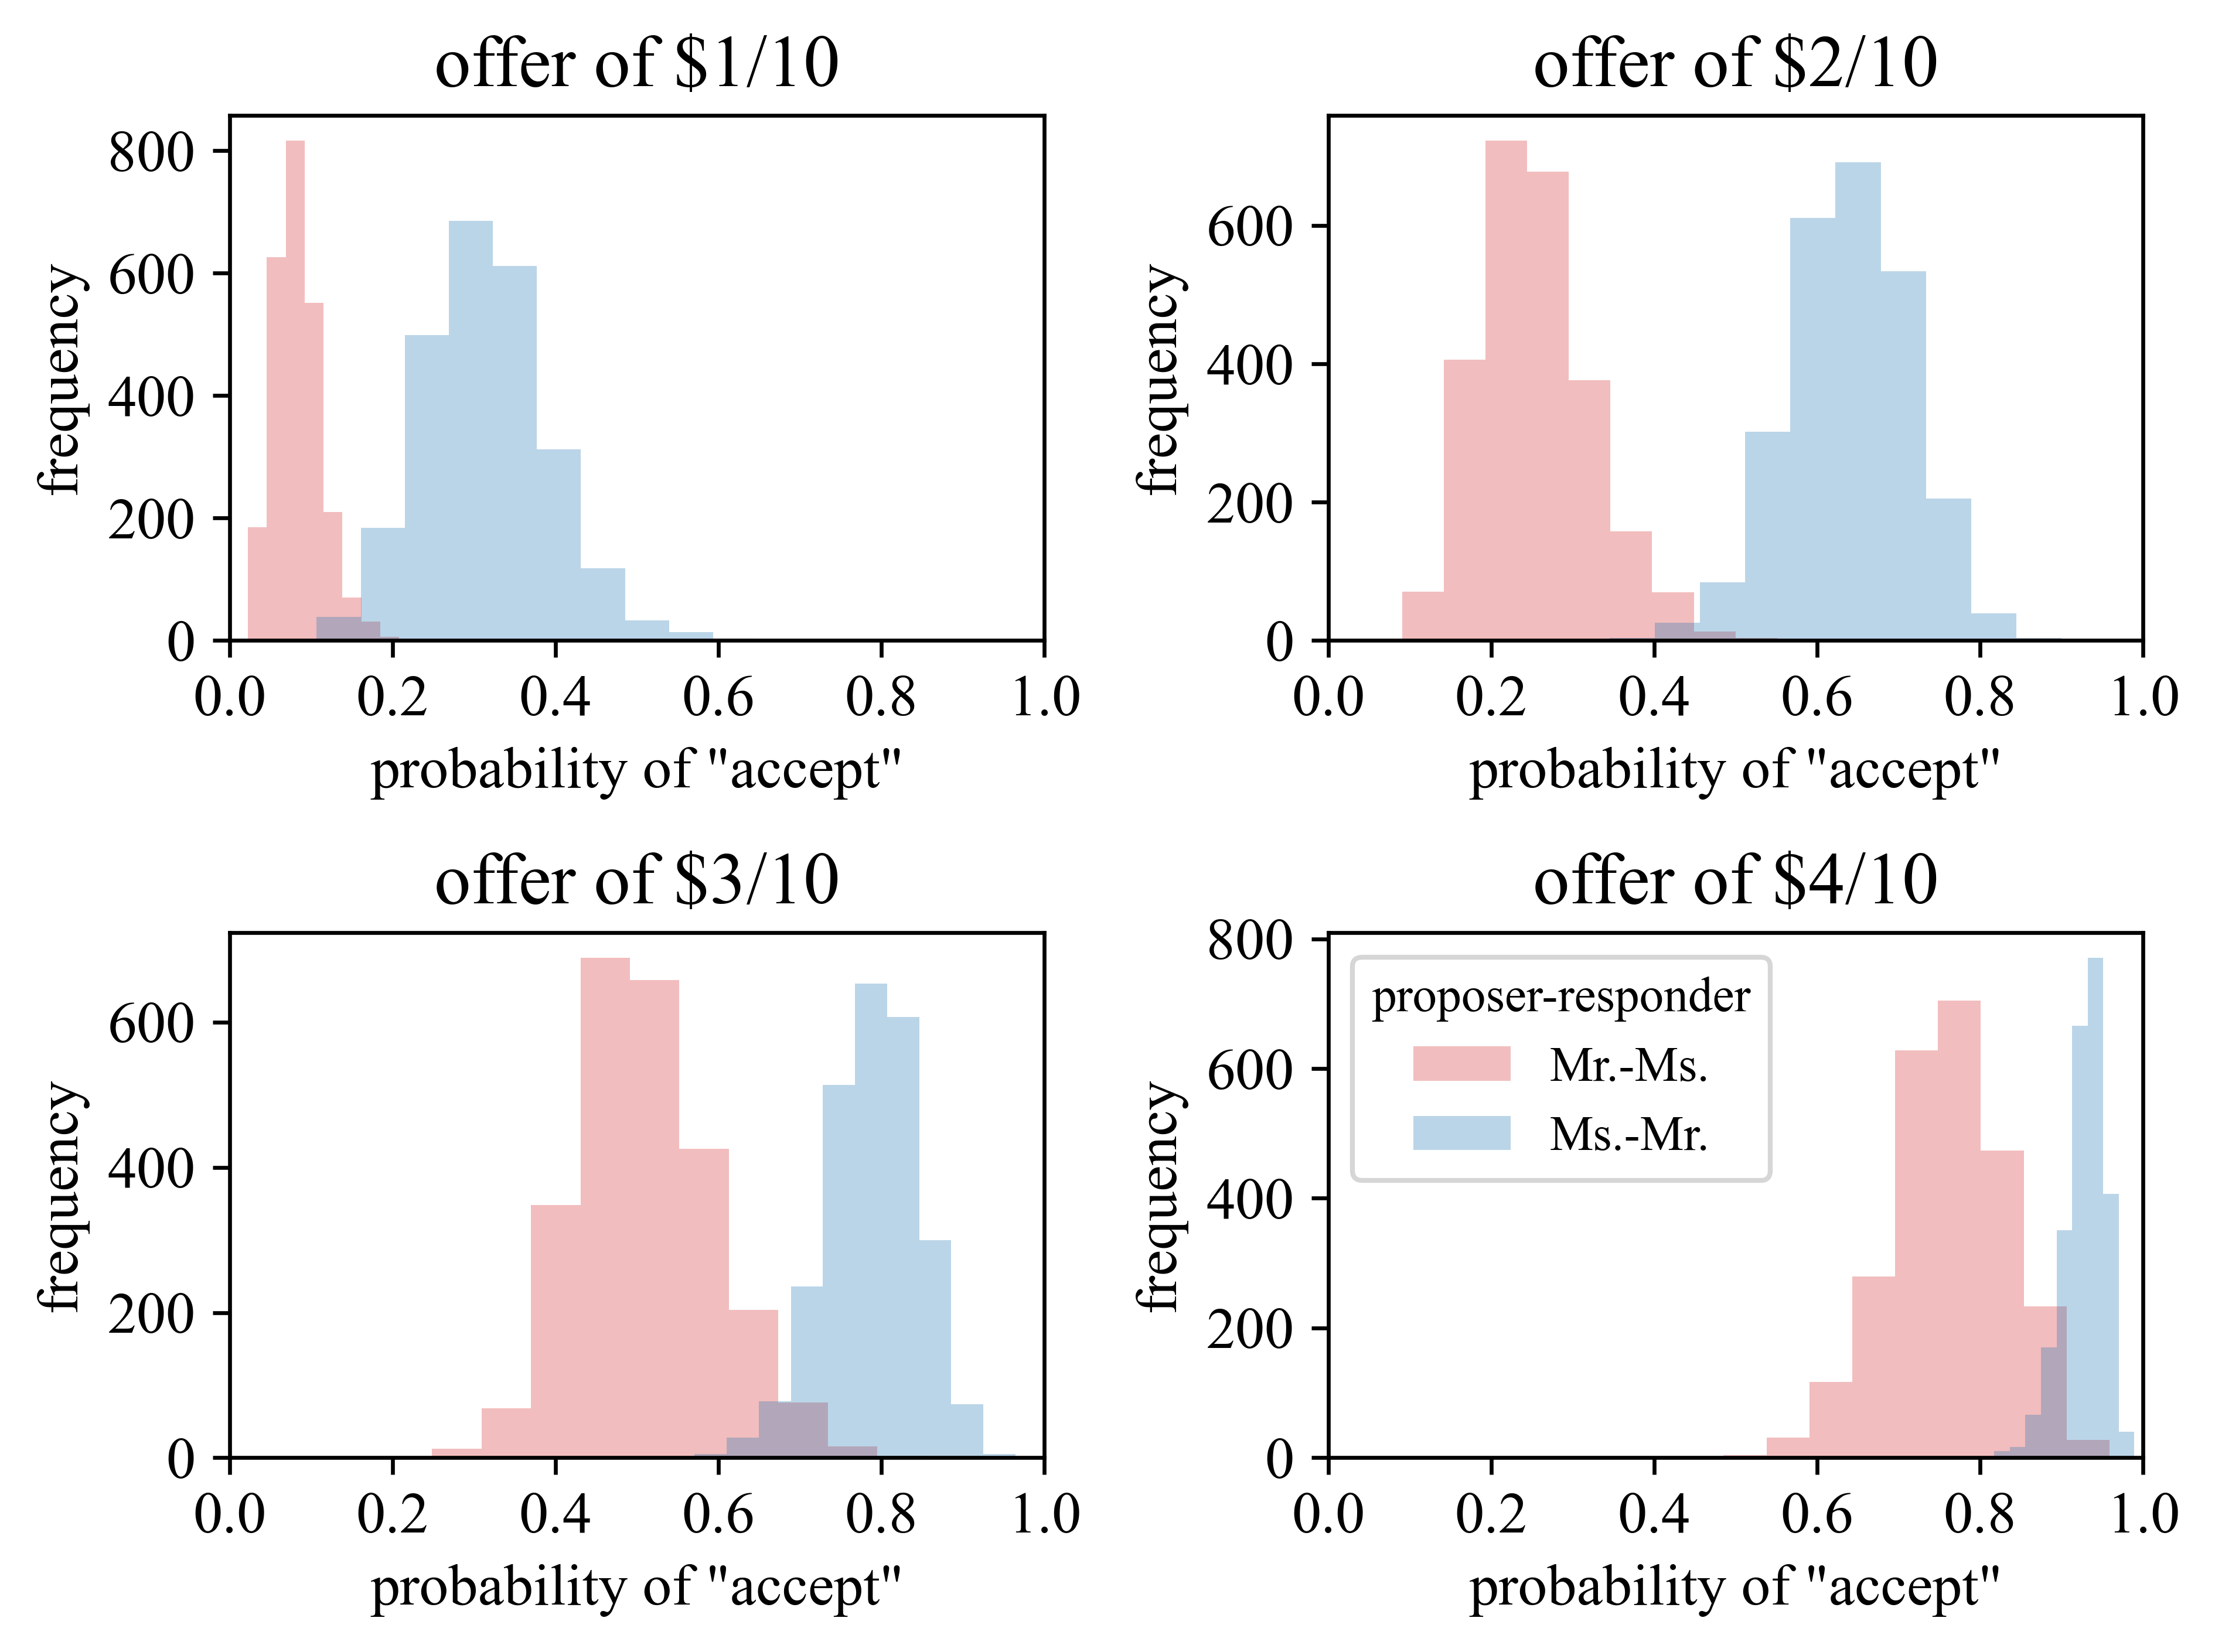

In [44]:
def plot_fig_ug_gender2(
        gender_pairs=['Mr.-Ms.', 'Ms.-Mr.'],
        colors = ['tab:red', 'tab:blue']
    ):
    engine = "text-davinci-002"
    table = dict_df_results[engine]

    fig, axes = plt.subplots(nrows=2, ncols=2, dpi=600)
    offer = 1
    for a in axes:
        for ax in a:
            for i, gp in enumerate(gender_pairs):
                table[
                    (table["offer"] == offer) & (table["gender_pair"] == gp)
                ]["p(accept)"].plot(
                    kind="hist", 
                    title=f"offer of \${offer}/10" if offer < 11 else "", 
                    alpha=0.3,
                    color=colors[i],
                    xlim=[0, 1],
                    ax=ax,
                    fontsize=12
                )
                ax.title.set_size(15)
                ax.set_xlabel('probability of "accept"', fontsize = 12)
                ax.set_ylabel('frequency', fontsize = 12)

            offer += 1
        axes[1][1].legend(gender_pairs, title="proposer-responder", title_fontsize=10)
        
        plt.savefig(
            path_to_figures_folder / f"{experiment_descriptor}_fig_ug_gender2.png", 
            bbox_inches='tight'
        )

plot_fig_ug_gender2()

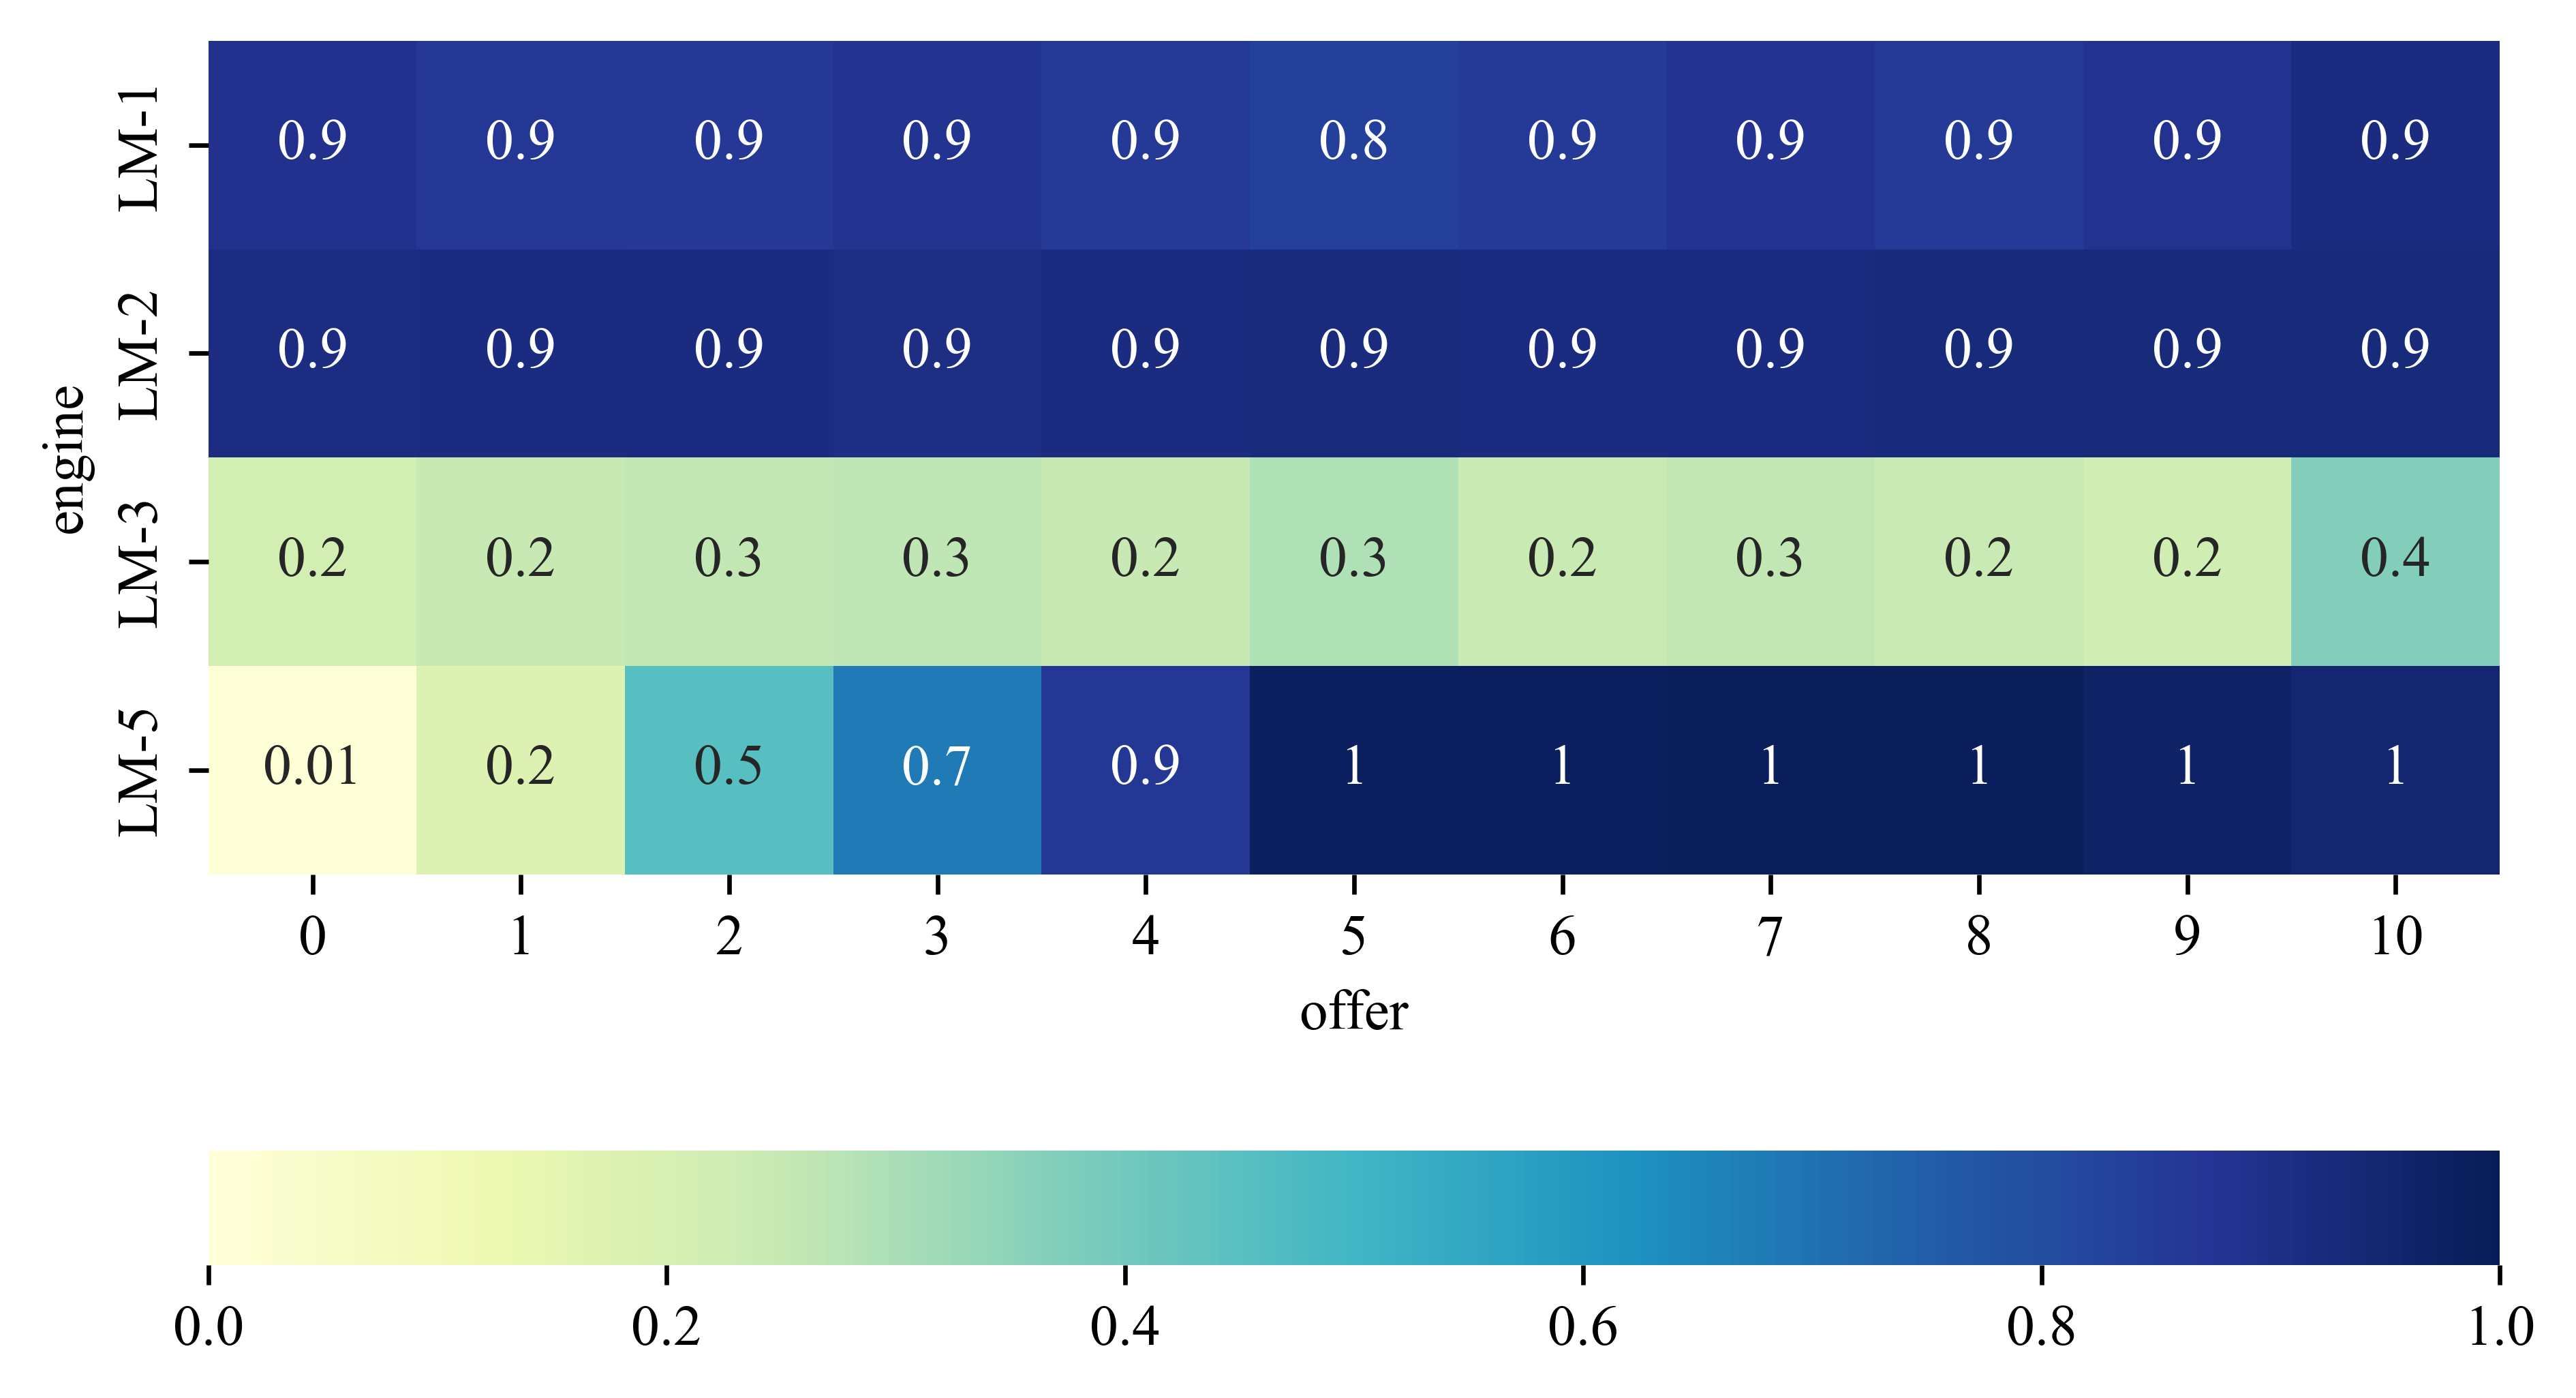

In [45]:
def plot_fig_ug_all_table():
    df_result_all = pd.concat([v for v in dict_df_results.values()])
    pivot_table_all = df_result_all.pivot_table(index="engine", columns="offer", values="p(accept)", aggfunc="mean")
    pivot_table_all = pivot_table_all.rename(
        index={
            "text-ada-001": "LM-1",
            "text-babbage-001": "LM-2",
            "text-curie-001": "LM-3",
            "text-davinci-001": "LM-4",
            "text-davinci-002": "LM-5",
        }
    )

    fig, ax = plt.subplots(dpi=600)
    sns.heatmap(
        pivot_table_all, cmap="YlGnBu", square=True, 
        vmin=0, vmax=1, ax=ax, fmt='.1n', annot=True, 
        cbar_kws={"orientation": "horizontal"}
    )

    plt.savefig(
        path_to_figures_folder / f"{experiment_descriptor}_fig_ug_all_table.png", 
        bbox_inches='tight'
    )

plot_fig_ug_all_table()